In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import UpscalePatchWGAN
from gantools.gansystem import GANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 64 # Resolution of the image
scaling = 16
try_resume = True

# Data handling

Load the data

In [4]:
dataset = data.load.load_maps_dataset(spix=ns, scaling=16, augmentation=True, patch=True)

images shape =  (200, 2304, 2560, 3)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 64, 64, 12)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

Display the histogram of the pixel densities after the forward map

min: 0.0038910505827516317
max: 0.9961089491844177


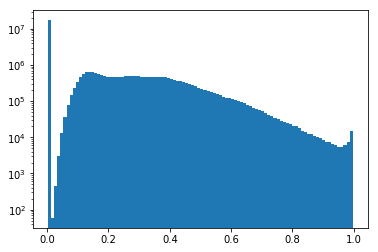

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [8]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

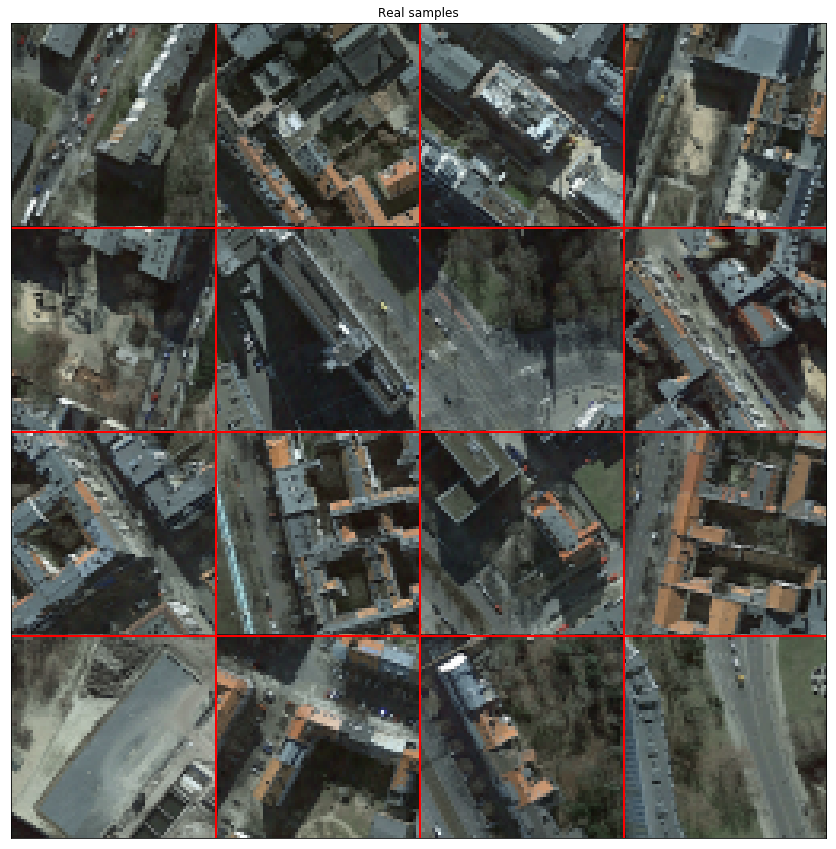

In [9]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16)[:,:,:,:3],nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [10]:
time_str = 'maps_scaling{}'.format(scaling)
global_path = '../saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [11]:
bn = True

def non_lin(x):
    return (tf.nn.tanh(x) + 1.0)/2.0

md=16

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 1, 1, 1, 1]
params_discriminator['nfilter'] = [md, 4*md, 16*md, 16*md, 16*md, 16*md, 2]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5], [5, 5], [5, 5],[5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn, bn, bn]
params_discriminator['full'] = [512, 256]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = True

params_generator = dict()
params_generator['stride'] = [1, 1, 1, 1, 1, 1, 1]
params_generator['latent_dim'] = 256
params_generator['nfilter'] = [md, md, md, md,md,md, 3]
params_generator['shape'] = [[5, 5], [5, 5],[5, 5], [5, 5],[5, 5],[5, 5], [5, 5]]
params_generator['batch_norm'] = [False, False, False, False, False, False]
params_generator['full'] = [64*64]
params_generator['summary'] = True
params_generator['non_lin'] = None
params_generator['data_size'] = 2
params_generator['borders'] = dict()
params_generator['borders']['nfilter'] = [12, 8, 4]
params_generator['borders']['batch_norm'] = [False, False, False]
params_generator['borders']['shape'] = [[5, 5], [5, 5],[5, 5],]
params_generator['borders']['stride'] = [2, 2, 2]
params_generator['borders']['data_size'] = 2
params_generator['borders']['width_full'] = None
params_generator['inception'] = True
params_generator['spectral_norm'] = True

params_optimization = dict()
params_optimization['batch_size'] = 16
params_optimization['epoch'] = 10000
params_optimization['n_critic'] = 2
params_optimization['generator'] = dict()
params_optimization['generator']['optimizer'] = 'adam'
params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['generator']['learning_rate'] = 0.0004
params_optimization['discriminator'] = dict()
params_optimization['discriminator']['optimizer'] = 'adam'
params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['discriminator']['learning_rate'] = 0.0001




# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 12] # Shape of the image
params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upsampling'] = None 

params['optimization'] = params_optimization
params['summary_every'] = 100 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 200

resume, params = utils.test_resume(try_resume, params)


No resume, the training will start from the beginning!


# Build the model

In [14]:
wgan = GANsystem(UpscalePatchWGAN, params)

Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 64, 64, 9)
     BORDER: 0 Conv layer with 12 channels
         BORDER:  Size of the conv variables: (?, 32, 32, 12)
     BORDER: 1 Conv layer with 8 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 8)
     BORDER: 2 Conv layer with 4 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 4)
     BORDER:  Size of the conv variables: (?, 256)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 512)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 64, 64, 1)
     0 Inception conv(1x1,3x3,5x5) layer with 16 channels
         Non linearity applied
         Size of the variables: (?, 64, 64, 48)
     1 Inception conv(1x1,3x3,5x5) layer with 16 channels
         Non linearity 

# Train the model

In [16]:
wgan.train(dataset, resume=resume)

Erase recursively directory: ../saved_results/WGAN64_maps_scaling16_summary/
Erase recursively directory: ../saved_results/WGAN64_maps_scaling16_checkpoints/
Start training
 * Epoch: [ 0] [  50/  50] Counter:50	( 0.5 min	26.409 examples/sec	0.61 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18342073
   Gen batch loss:1.81866801	Gen epoch loss:1.69938751
 * Epoch: [ 1] [  50/  50] Counter:100	( 0.9 min	37.522 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05666219
   Gen batch loss:4.26951742	Gen epoch loss:2.37327381
 * Epoch: [ 2] [  50/  50] Counter:150	( 1.4 min	25.385 examples/sec	0.63 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02461918
   Gen batch loss:1.25141490	Gen epoch loss:2.88447219
 * Epoch: [ 3] [  50/  50] Counter:200	( 1.7 min	37.458 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03315895
   Gen batch loss:1.04501116	Gen epoch loss:3.45882398
 * Epoch: [ 4] [  50/  50] Counter:250	(

 * Epoch: [41] [  50/  50] Counter:2100	(15.6 min	37.255 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.83660841	Gen epoch loss:4.65613577
 * Epoch: [42] [  50/  50] Counter:2150	(16.0 min	36.223 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00266544
   Gen batch loss:5.03694010	Gen epoch loss:4.27229423
 * Epoch: [43] [  50/  50] Counter:2200	(16.3 min	37.047 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.53653669	Gen epoch loss:4.02867382
 * Epoch: [44] [  50/  50] Counter:2250	(16.7 min	36.359 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.32072067	Gen epoch loss:4.18138849
 * Epoch: [45] [  50/  50] Counter:2300	(17.0 min	37.026 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00357820
   Gen batch loss:5.43497133	Gen epoch loss:4.07417897
 * Epoch: 

 * Epoch: [83] [  50/  50] Counter:4200	(30.9 min	36.981 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00107504
   Gen batch loss:3.62779737	Gen epoch loss:4.06408887
 * Epoch: [84] [  50/  50] Counter:4250	(31.3 min	36.211 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.39885092	Gen epoch loss:4.55763386
 * Epoch: [85] [  50/  50] Counter:4300	(31.7 min	36.993 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00051069
   Gen batch loss:4.76915741	Gen epoch loss:3.85029455
 * Epoch: [86] [  50/  50] Counter:4350	(32.0 min	36.170 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.67444277	Gen epoch loss:4.15194937
 * Epoch: [87] [  50/  50] Counter:4400	(32.4 min	37.091 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.64343214	Gen epoch loss:4.18368567
 * Epoch: 

 * Epoch: [125] [  50/  50] Counter:6300	(46.3 min	36.948 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00211960
   Gen batch loss:3.85338926	Gen epoch loss:3.94049660
 * Epoch: [126] [  50/  50] Counter:6350	(46.6 min	36.210 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02700781
   Gen batch loss:1.56221485	Gen epoch loss:4.69226092
 * Epoch: [127] [  50/  50] Counter:6400	(47.0 min	36.905 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03718225
   Gen batch loss:4.19519663	Gen epoch loss:4.35627301
 * Epoch: [128] [  50/  50] Counter:6450	(47.4 min	36.250 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02005637
   Gen batch loss:2.31746101	Gen epoch loss:4.05499804
 * Epoch: [129] [  50/  50] Counter:6500	(47.7 min	36.925 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00087463
   Gen batch loss:1.77331972	Gen epoch loss:4.24906246
 * Ep

 * Epoch: [167] [  50/  50] Counter:8400	(61.6 min	36.997 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.94960594	Gen epoch loss:6.49193295
 * Epoch: [168] [  50/  50] Counter:8450	(62.0 min	36.208 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.62540555	Gen epoch loss:4.70595679
 * Epoch: [169] [  50/  50] Counter:8500	(62.3 min	36.952 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.57554770	Gen epoch loss:6.14808233
 * Epoch: [170] [  50/  50] Counter:8550	(62.7 min	36.137 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.17487621	Gen epoch loss:5.59237046
 * Epoch: [171] [  50/  50] Counter:8600	(63.1 min	36.912 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.97992706	Gen epoch loss:5.15911951
 * Ep

 * Epoch: [208] [  50/  50] Counter:10450	(76.6 min	36.159 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01418472
   Gen batch loss:7.49714279	Gen epoch loss:7.22370228
 * Epoch: [209] [  50/  50] Counter:10500	(77.0 min	37.131 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.99900436	Gen epoch loss:5.62640611
 * Epoch: [210] [  50/  50] Counter:10550	(77.3 min	36.126 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.40946484	Gen epoch loss:5.98107656
 * Epoch: [211] [  50/  50] Counter:10600	(77.7 min	37.071 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.07161427	Gen epoch loss:5.99051744
 * Epoch: [212] [  50/  50] Counter:10650	(78.1 min	36.293 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.39426804	Gen epoch loss:5.44602266


 * Epoch: [249] [  50/  50] Counter:12500	(91.6 min	36.517 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.19653058	Gen epoch loss:3.25052824
 * Epoch: [250] [  50/  50] Counter:12550	(92.0 min	36.412 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.98404169	Gen epoch loss:4.00947385
 * Epoch: [251] [  50/  50] Counter:12600	(92.4 min	36.703 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.15364265	Gen epoch loss:3.83383238
 * Epoch: [252] [  50/  50] Counter:12650	(92.7 min	35.722 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.24930644	Gen epoch loss:3.71097806
 * Epoch: [253] [  50/  50] Counter:12700	(93.1 min	36.768 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.28769231	Gen epoch loss:3.96945502


 * Epoch: [290] [  50/  50] Counter:14550	(106.7 min	35.982 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.69584084	Gen epoch loss:3.73615216
 * Epoch: [291] [  50/  50] Counter:14600	(107.0 min	37.214 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.63647223	Gen epoch loss:5.12107087
 * Epoch: [292] [  50/  50] Counter:14650	(107.4 min	35.894 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.22559929	Gen epoch loss:6.79046486
 * Epoch: [293] [  50/  50] Counter:14700	(107.8 min	36.960 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.36071920	Gen epoch loss:6.33356741
 * Epoch: [294] [  50/  50] Counter:14750	(108.1 min	36.040 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00528949
   Gen batch loss:1.83029771	Gen epoch loss:6.555

 * Epoch: [331] [  50/  50] Counter:16600	(121.7 min	36.727 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.99919033	Gen epoch loss:5.61356224
 * Epoch: [332] [  50/  50] Counter:16650	(122.1 min	35.864 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.08000851	Gen epoch loss:4.52285653
 * Epoch: [333] [  50/  50] Counter:16700	(122.4 min	36.769 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01827984
   Gen batch loss:6.12591743	Gen epoch loss:5.55614217
 * Epoch: [334] [  50/  50] Counter:16750	(122.8 min	36.174 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.22680235	Gen epoch loss:5.09522254
 * Epoch: [335] [  50/  50] Counter:16800	(123.2 min	36.738 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00253534
   Gen batch loss:11.00836945	Gen epoch loss:4.846

 * Epoch: [372] [  50/  50] Counter:18650	(136.7 min	36.029 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.28123999	Gen epoch loss:6.45686238
 * Epoch: [373] [  50/  50] Counter:18700	(137.1 min	36.696 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.84116364	Gen epoch loss:5.80884001
 * Epoch: [374] [  50/  50] Counter:18750	(137.5 min	36.174 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.71517622	Gen epoch loss:6.22008123
 * Epoch: [375] [  50/  50] Counter:18800	(137.8 min	36.855 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.04327202	Gen epoch loss:5.72155328
 * Epoch: [376] [  50/  50] Counter:18850	(138.2 min	35.986 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.40973759	Gen epoch loss:5.8542

 * Epoch: [413] [  50/  50] Counter:20700	(151.8 min	36.995 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00046121
   Gen batch loss:5.64615250	Gen epoch loss:5.79102985
 * Epoch: [414] [  50/  50] Counter:20750	(152.1 min	36.518 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.36170721	Gen epoch loss:6.03709855
 * Epoch: [415] [  50/  50] Counter:20800	(152.5 min	36.722 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.27953100	Gen epoch loss:5.28165229
 * Epoch: [416] [  50/  50] Counter:20850	(152.9 min	36.182 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.67572212	Gen epoch loss:5.65353828
 * Epoch: [417] [  50/  50] Counter:20900	(153.2 min	36.971 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.89466858	Gen epoch loss:5.526

 * Epoch: [454] [  50/  50] Counter:22750	(166.8 min	36.027 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.84973764	Gen epoch loss:5.59306334
 * Epoch: [455] [  50/  50] Counter:22800	(167.2 min	36.564 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.82769156	Gen epoch loss:6.49533993
 * Epoch: [456] [  50/  50] Counter:22850	(167.5 min	36.606 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.68604851	Gen epoch loss:5.57148812
 * Epoch: [457] [  50/  50] Counter:22900	(167.9 min	36.523 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.07064629	Gen epoch loss:6.59302646
 * Epoch: [458] [  50/  50] Counter:22950	(168.3 min	35.925 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.78792095	Gen epoch loss:6.2551

 * Epoch: [495] [  50/  50] Counter:24800	(181.8 min	36.979 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.70064068	Gen epoch loss:5.77018048
 * Epoch: [496] [  50/  50] Counter:24850	(182.2 min	35.939 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.37699127	Gen epoch loss:5.82492497
 * Epoch: [497] [  50/  50] Counter:24900	(182.5 min	37.174 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.05911827	Gen epoch loss:7.13273724
 * Epoch: [498] [  50/  50] Counter:24950	(182.9 min	36.110 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.13587666	Gen epoch loss:6.41070518
 * Epoch: [499] [  50/  50] Counter:25000	(183.3 min	36.643 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.89958763	Gen epoch loss:6.3743

 * Epoch: [536] [  50/  50] Counter:26850	(196.8 min	36.256 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.42513084	Gen epoch loss:6.35098799
 * Epoch: [537] [  50/  50] Counter:26900	(197.2 min	37.341 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00530473
   Gen batch loss:8.23408222	Gen epoch loss:5.99519050
 * Epoch: [538] [  50/  50] Counter:26950	(197.6 min	36.122 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.35128403	Gen epoch loss:5.68706094
 * Epoch: [539] [  50/  50] Counter:27000	(197.9 min	36.852 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.16824174	Gen epoch loss:5.47277500
Model saved!
 * Epoch: [540] [  50/  50] Counter:27050	(198.3 min	33.718 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.07045841	Gen epoc

 * Epoch: [577] [  50/  50] Counter:28900	(211.9 min	36.799 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.59036160	Gen epoch loss:5.68491241
 * Epoch: [578] [  50/  50] Counter:28950	(212.2 min	36.079 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.67147017	Gen epoch loss:5.40918633
 * Epoch: [579] [  50/  50] Counter:29000	(212.6 min	36.557 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.79512882	Gen epoch loss:7.20190501
Model saved!
 * Epoch: [580] [  50/  50] Counter:29050	(213.0 min	33.768 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.55969715	Gen epoch loss:5.42180349
 * Epoch: [581] [  50/  50] Counter:29100	(213.3 min	37.211 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01381488
   Gen batch loss:4.95476198	Gen epo

 * Epoch: [618] [  50/  50] Counter:30950	(226.9 min	35.805 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.55138612	Gen epoch loss:4.73798475
 * Epoch: [619] [  50/  50] Counter:31000	(227.3 min	36.882 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.90686941	Gen epoch loss:5.26988139
Model saved!
 * Epoch: [620] [  50/  50] Counter:31050	(227.7 min	33.405 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.70287991	Gen epoch loss:4.59032195
 * Epoch: [621] [  50/  50] Counter:31100	(228.0 min	36.860 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.23827863	Gen epoch loss:5.59441386
 * Epoch: [622] [  50/  50] Counter:31150	(228.4 min	36.118 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04424451
   Gen batch loss:6.47790623	Gen epoc

 * Epoch: [659] [  50/  50] Counter:33000	(242.0 min	36.479 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.30754852	Gen epoch loss:5.40891889
Model saved!
 * Epoch: [660] [  50/  50] Counter:33050	(242.4 min	33.849 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.54257393	Gen epoch loss:4.33963240
 * Epoch: [661] [  50/  50] Counter:33100	(242.8 min	36.597 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.09863377	Gen epoch loss:5.74029891
 * Epoch: [662] [  50/  50] Counter:33150	(243.2 min	36.077 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.96671867	Gen epoch loss:4.73560476
 * Epoch: [663] [  50/  50] Counter:33200	(243.5 min	36.632 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.00171518	Gen epoc

 * Epoch: [705] [  50/  50] Counter:35300	(259.0 min	36.827 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.41662169	Gen epoch loss:5.60499450
 * Epoch: [706] [  50/  50] Counter:35350	(259.4 min	36.013 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.25485945	Gen epoch loss:6.29959828
 * Epoch: [707] [  50/  50] Counter:35400	(259.7 min	36.990 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.71480942	Gen epoch loss:7.06427809
 * Epoch: [708] [  50/  50] Counter:35450	(260.1 min	36.167 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03120538
   Gen batch loss:14.52211952	Gen epoch loss:7.13721226
 * Epoch: [709] [  50/  50] Counter:35500	(260.5 min	36.440 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.80028152	Gen epoch loss:8.108

 * Epoch: [746] [  50/  50] Counter:37350	(274.1 min	36.071 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.66346979	Gen epoch loss:6.63336400
 * Epoch: [747] [  50/  50] Counter:37400	(274.4 min	36.629 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.03009987	Gen epoch loss:7.51325175
 * Epoch: [748] [  50/  50] Counter:37450	(274.8 min	35.912 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.56192970	Gen epoch loss:6.68620273
 * Epoch: [749] [  50/  50] Counter:37500	(275.2 min	37.138 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.88874829	Gen epoch loss:6.66656272
 * Epoch: [750] [  50/  50] Counter:37550	(275.5 min	35.955 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01597237
   Gen batch loss:5.71921301	Gen epoch loss:6.8434

 * Epoch: [787] [  50/  50] Counter:39400	(289.1 min	36.571 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00207054
   Gen batch loss:8.98961639	Gen epoch loss:7.90047956
 * Epoch: [788] [  50/  50] Counter:39450	(289.5 min	36.117 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.20070267	Gen epoch loss:7.34164009
 * Epoch: [789] [  50/  50] Counter:39500	(289.9 min	37.169 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.59482002	Gen epoch loss:6.32168697
 * Epoch: [790] [  50/  50] Counter:39550	(290.2 min	35.814 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00102486
   Gen batch loss:2.43212652	Gen epoch loss:6.95296016
 * Epoch: [791] [  50/  50] Counter:39600	(290.6 min	36.788 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.52742672	Gen epoch loss:7.8476

 * Epoch: [828] [  50/  50] Counter:41450	(304.2 min	36.448 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.16852665	Gen epoch loss:7.89946618
 * Epoch: [829] [  50/  50] Counter:41500	(304.6 min	36.549 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.81730652	Gen epoch loss:7.73183626
 * Epoch: [830] [  50/  50] Counter:41550	(304.9 min	35.878 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.78345966	Gen epoch loss:6.92697520
 * Epoch: [831] [  50/  50] Counter:41600	(305.3 min	36.921 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.79001808	Gen epoch loss:7.99904732
 * Epoch: [832] [  50/  50] Counter:41650	(305.7 min	36.286 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02302009
   Gen batch loss:5.36767101	Gen epoch loss:7.948

 * Epoch: [869] [  50/  50] Counter:43500	(319.3 min	36.985 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00377396
   Gen batch loss:13.95449543	Gen epoch loss:7.36381976
 * Epoch: [870] [  50/  50] Counter:43550	(319.6 min	35.995 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00272053
   Gen batch loss:4.71645832	Gen epoch loss:7.48171108
 * Epoch: [871] [  50/  50] Counter:43600	(320.0 min	36.452 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.12324619	Gen epoch loss:6.29586802
 * Epoch: [872] [  50/  50] Counter:43650	(320.4 min	35.757 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00053440
   Gen batch loss:14.68108368	Gen epoch loss:8.36846858
 * Epoch: [873] [  50/  50] Counter:43700	(320.7 min	37.214 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.89740086	Gen epoch loss:7.0

 * Epoch: [910] [  50/  50] Counter:45550	(334.3 min	36.092 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01324633
   Gen batch loss:10.28701878	Gen epoch loss:6.34566022
 * Epoch: [911] [  50/  50] Counter:45600	(334.7 min	36.768 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00069420
   Gen batch loss:8.26233673	Gen epoch loss:6.42647298
 * Epoch: [912] [  50/  50] Counter:45650	(335.1 min	35.717 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.64012444	Gen epoch loss:7.75335325
 * Epoch: [913] [  50/  50] Counter:45700	(335.4 min	36.963 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00735606
   Gen batch loss:2.67932892	Gen epoch loss:7.08392169
 * Epoch: [914] [  50/  50] Counter:45750	(335.8 min	36.150 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.26470947	Gen epoch loss:6.711

 * Epoch: [951] [  50/  50] Counter:47600	(349.4 min	36.563 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01652562
   Gen batch loss:5.20887375	Gen epoch loss:7.07086117
 * Epoch: [952] [  50/  50] Counter:47650	(349.8 min	35.912 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.44332027	Gen epoch loss:6.56482032
 * Epoch: [953] [  50/  50] Counter:47700	(350.1 min	37.101 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.78337193	Gen epoch loss:6.88381731
 * Epoch: [954] [  50/  50] Counter:47750	(350.5 min	36.017 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.39160681	Gen epoch loss:7.09554082
 * Epoch: [955] [  50/  50] Counter:47800	(350.9 min	36.474 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.95988274	Gen epoch loss:6.616

 * Epoch: [992] [  50/  50] Counter:49650	(364.5 min	36.004 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.58269882	Gen epoch loss:8.01672961
 * Epoch: [993] [  50/  50] Counter:49700	(364.9 min	36.878 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00310037
   Gen batch loss:2.78271580	Gen epoch loss:7.16437312
 * Epoch: [994] [  50/  50] Counter:49750	(365.2 min	35.653 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.32380104	Gen epoch loss:7.49959496
 * Epoch: [995] [  50/  50] Counter:49800	(365.6 min	36.612 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.75526810	Gen epoch loss:7.41977785
 * Epoch: [996] [  50/  50] Counter:49850	(366.0 min	36.339 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.79907417	Gen epoch loss:8.5

 * Epoch: [1033] [  50/  50] Counter:51700	(379.6 min	36.602 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.76372910	Gen epoch loss:8.57237545
 * Epoch: [1034] [  50/  50] Counter:51750	(380.0 min	35.999 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03037086
   Gen batch loss:4.05484581	Gen epoch loss:7.66135108
 * Epoch: [1035] [  50/  50] Counter:51800	(380.3 min	37.110 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.51612854	Gen epoch loss:7.35524210
 * Epoch: [1036] [  50/  50] Counter:51850	(380.7 min	35.796 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00059122
   Gen batch loss:8.73689365	Gen epoch loss:7.61282556
 * Epoch: [1037] [  50/  50] Counter:51900	(381.1 min	36.558 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.66522694	Gen epoch loss:

 * Epoch: [1074] [  50/  50] Counter:53750	(394.7 min	36.136 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.84242272	Gen epoch loss:8.10813778
 * Epoch: [1075] [  50/  50] Counter:53800	(395.0 min	36.777 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.98187828	Gen epoch loss:6.79942278
 * Epoch: [1076] [  50/  50] Counter:53850	(395.4 min	35.998 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.55755424	Gen epoch loss:6.78589141
 * Epoch: [1077] [  50/  50] Counter:53900	(395.8 min	37.120 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.78019953	Gen epoch loss:6.69868714
 * Epoch: [1078] [  50/  50] Counter:53950	(396.1 min	35.957 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.01308346	Gen epoch loss:

 * Epoch: [1115] [  50/  50] Counter:55800	(409.7 min	36.474 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00080032
   Gen batch loss:12.54420853	Gen epoch loss:6.53370648
 * Epoch: [1116] [  50/  50] Counter:55850	(410.1 min	36.309 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.45114326	Gen epoch loss:7.25987673
 * Epoch: [1117] [  50/  50] Counter:55900	(410.5 min	36.532 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.65807819	Gen epoch loss:7.15729330
 * Epoch: [1118] [  50/  50] Counter:55950	(410.8 min	35.845 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.41291428	Gen epoch loss:6.23577589
 * Epoch: [1119] [  50/  50] Counter:56000	(411.2 min	36.806 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.94335556	Gen epoch loss

 * Epoch: [1156] [  50/  50] Counter:57850	(424.8 min	36.188 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.59104443	Gen epoch loss:6.03639806
 * Epoch: [1157] [  50/  50] Counter:57900	(425.2 min	36.413 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.73700380	Gen epoch loss:6.96720200
 * Epoch: [1158] [  50/  50] Counter:57950	(425.6 min	36.150 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.62661648	Gen epoch loss:7.11887204
 * Epoch: [1159] [  50/  50] Counter:58000	(425.9 min	36.677 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00059235
   Gen batch loss:4.19571829	Gen epoch loss:6.28059643
Model saved!
 * Epoch: [1160] [  50/  50] Counter:58050	(426.3 min	33.945 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.49792385	Gen

 * Epoch: [1197] [  50/  50] Counter:59900	(439.9 min	36.710 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.94772601	Gen epoch loss:6.02201651
 * Epoch: [1198] [  50/  50] Counter:59950	(440.3 min	36.136 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.35839272	Gen epoch loss:6.79682588
 * Epoch: [1199] [  50/  50] Counter:60000	(440.6 min	36.734 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.04123688	Gen epoch loss:7.27374471
Model saved!
 * Epoch: [1200] [  50/  50] Counter:60050	(441.0 min	33.485 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01119428
   Gen batch loss:1.23096156	Gen epoch loss:7.94394842
 * Epoch: [1201] [  50/  50] Counter:60100	(441.4 min	37.168 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.56696415	Ge

 * Epoch: [1238] [  50/  50] Counter:61950	(455.0 min	36.005 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.77209282	Gen epoch loss:3.83702252
 * Epoch: [1239] [  50/  50] Counter:62000	(455.4 min	36.696 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.48949623	Gen epoch loss:5.51154051
Model saved!
 * Epoch: [1240] [  50/  50] Counter:62050	(455.8 min	33.541 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.67784405	Gen epoch loss:5.77737716
 * Epoch: [1241] [  50/  50] Counter:62100	(456.1 min	36.772 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.45980120	Gen epoch loss:4.94609249
 * Epoch: [1242] [  50/  50] Counter:62150	(456.5 min	35.866 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.24888229	Gen

 * Epoch: [1279] [  50/  50] Counter:64000	(470.1 min	36.474 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.07244825	Gen epoch loss:7.17895881
Model saved!
 * Epoch: [1280] [  50/  50] Counter:64050	(470.5 min	33.789 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.13006306	Gen epoch loss:6.36510370
 * Epoch: [1281] [  50/  50] Counter:64100	(470.8 min	36.829 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08558278
   Gen batch loss:16.74879646	Gen epoch loss:7.28933632
 * Epoch: [1282] [  50/  50] Counter:64150	(471.2 min	35.808 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.09960318	Gen epoch loss:6.88451345
 * Epoch: [1283] [  50/  50] Counter:64200	(471.6 min	37.167 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.25047398	Ge

Model saved!
 * Epoch: [1320] [  50/  50] Counter:66050	(485.2 min	34.103 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.50940800	Gen epoch loss:6.83060381
 * Epoch: [1321] [  50/  50] Counter:66100	(485.5 min	36.562 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02890223
   Gen batch loss:8.90269279	Gen epoch loss:7.62836742
 * Epoch: [1322] [  50/  50] Counter:66150	(485.9 min	36.034 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.44498253	Gen epoch loss:6.35167271
 * Epoch: [1323] [  50/  50] Counter:66200	(486.3 min	36.958 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.06582546	Gen epoch loss:8.04840716
 * Epoch: [1324] [  50/  50] Counter:66250	(486.6 min	36.120 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.51596069	Gen

 * Epoch: [1361] [  50/  50] Counter:68100	(500.2 min	36.593 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.28862906	Gen epoch loss:7.09697518
 * Epoch: [1362] [  50/  50] Counter:68150	(500.6 min	36.050 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.75695944	Gen epoch loss:6.86190028
 * Epoch: [1363] [  50/  50] Counter:68200	(501.0 min	36.938 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.50256968	Gen epoch loss:6.86200732
 * Epoch: [1364] [  50/  50] Counter:68250	(501.3 min	36.169 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.73715448	Gen epoch loss:6.41525296
 * Epoch: [1365] [  50/  50] Counter:68300	(501.7 min	36.523 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.65446663	Gen epoch loss:7

 * Epoch: [1402] [  50/  50] Counter:70150	(515.3 min	35.764 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.45565319	Gen epoch loss:6.71880202
 * Epoch: [1403] [  50/  50] Counter:70200	(515.7 min	37.182 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.49359870	Gen epoch loss:6.59919960
 * Epoch: [1404] [  50/  50] Counter:70250	(516.1 min	36.065 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00527700
   Gen batch loss:7.02463341	Gen epoch loss:6.29520747
 * Epoch: [1405] [  50/  50] Counter:70300	(516.4 min	36.556 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02039309
   Gen batch loss:7.19983482	Gen epoch loss:6.96555226
 * Epoch: [1406] [  50/  50] Counter:70350	(516.8 min	35.822 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.16304207	Gen epoch loss:6

 * Epoch: [1443] [  50/  50] Counter:72200	(530.4 min	37.253 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.18773365	Gen epoch loss:7.29278985
 * Epoch: [1444] [  50/  50] Counter:72250	(530.7 min	35.916 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.92708778	Gen epoch loss:6.10437944
 * Epoch: [1445] [  50/  50] Counter:72300	(531.1 min	36.501 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.57341385	Gen epoch loss:7.38195576
 * Epoch: [1446] [  50/  50] Counter:72350	(531.5 min	36.271 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.56422329	Gen epoch loss:7.07032162
 * Epoch: [1447] [  50/  50] Counter:72400	(531.8 min	37.136 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.96227169	Gen epoch loss:8

 * Epoch: [1484] [  50/  50] Counter:74250	(545.4 min	36.030 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00151567
   Gen batch loss:7.84712458	Gen epoch loss:7.28903095
 * Epoch: [1485] [  50/  50] Counter:74300	(545.8 min	37.247 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.02950191	Gen epoch loss:7.19094098
 * Epoch: [1486] [  50/  50] Counter:74350	(546.1 min	36.250 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.29638481	Gen epoch loss:7.72877673
 * Epoch: [1487] [  50/  50] Counter:74400	(546.5 min	36.717 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.90143585	Gen epoch loss:7.25062251
 * Epoch: [1488] [  50/  50] Counter:74450	(546.9 min	36.250 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.89898205	Gen epoch loss

 * Epoch: [1525] [  50/  50] Counter:76300	(560.4 min	37.283 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.79371691	Gen epoch loss:5.07291984
 * Epoch: [1526] [  50/  50] Counter:76350	(560.8 min	35.876 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.13541794	Gen epoch loss:7.59365142
 * Epoch: [1527] [  50/  50] Counter:76400	(561.2 min	36.680 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.45034075	Gen epoch loss:7.34249557
 * Epoch: [1528] [  50/  50] Counter:76450	(561.5 min	36.350 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.82726431	Gen epoch loss:6.65965361
 * Epoch: [1529] [  50/  50] Counter:76500	(561.9 min	36.895 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.06504440	Gen epoch loss:

 * Epoch: [1566] [  50/  50] Counter:78350	(575.5 min	36.044 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.73148060	Gen epoch loss:7.31564516
 * Epoch: [1567] [  50/  50] Counter:78400	(575.8 min	36.691 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.47727966	Gen epoch loss:6.75769312
 * Epoch: [1568] [  50/  50] Counter:78450	(576.2 min	36.484 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00026487
   Gen batch loss:4.35708570	Gen epoch loss:6.09997179
 * Epoch: [1569] [  50/  50] Counter:78500	(576.6 min	36.777 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00052619
   Gen batch loss:8.03120804	Gen epoch loss:5.62173876
 * Epoch: [1570] [  50/  50] Counter:78550	(576.9 min	35.957 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07218163
   Gen batch loss:9.08351326	Gen epoch loss:

 * Epoch: [1607] [  50/  50] Counter:80400	(590.5 min	36.865 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02395118
   Gen batch loss:7.11070538	Gen epoch loss:8.95728668
 * Epoch: [1608] [  50/  50] Counter:80450	(590.9 min	36.195 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.17273235	Gen epoch loss:6.84801586
 * Epoch: [1609] [  50/  50] Counter:80500	(591.2 min	37.038 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06590218
   Gen batch loss:10.27363205	Gen epoch loss:7.09593034
 * Epoch: [1610] [  50/  50] Counter:80550	(591.6 min	35.946 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.31553268	Gen epoch loss:7.63003484
 * Epoch: [1611] [  50/  50] Counter:80600	(592.0 min	36.912 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.71232605	Gen epoch loss:

 * Epoch: [1648] [  50/  50] Counter:82450	(605.5 min	36.363 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.70498276	Gen epoch loss:7.51394916
 * Epoch: [1649] [  50/  50] Counter:82500	(605.9 min	36.767 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.62376881	Gen epoch loss:7.91233642
 * Epoch: [1650] [  50/  50] Counter:82550	(606.3 min	35.957 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.52965832	Gen epoch loss:8.09399337
 * Epoch: [1651] [  50/  50] Counter:82600	(606.6 min	37.423 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00132971
   Gen batch loss:2.64438391	Gen epoch loss:6.87278966
 * Epoch: [1652] [  50/  50] Counter:82650	(607.0 min	35.783 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.24998856	Gen epoch loss:7

 * Epoch: [1689] [  50/  50] Counter:84500	(620.6 min	36.491 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05673649
   Gen batch loss:9.04722214	Gen epoch loss:6.24373639
 * Epoch: [1690] [  50/  50] Counter:84550	(620.9 min	36.271 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.65290546	Gen epoch loss:7.18780382
 * Epoch: [1691] [  50/  50] Counter:84600	(621.3 min	37.176 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.96428156	Gen epoch loss:5.96533044
 * Epoch: [1692] [  50/  50] Counter:84650	(621.7 min	35.897 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03780747
   Gen batch loss:6.14565372	Gen epoch loss:8.17189844
 * Epoch: [1693] [  50/  50] Counter:84700	(622.0 min	36.885 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.82349968	Gen epoch loss:

 * Epoch: [1730] [  50/  50] Counter:86550	(635.6 min	36.046 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.95406246	Gen epoch loss:8.74631900
 * Epoch: [1731] [  50/  50] Counter:86600	(636.0 min	36.863 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.34351575	Gen epoch loss:9.26600241
 * Epoch: [1732] [  50/  50] Counter:86650	(636.3 min	35.833 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.36153901	Gen epoch loss:7.88510115
 * Epoch: [1733] [  50/  50] Counter:86700	(636.7 min	36.959 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.37242126	Gen epoch loss:7.80258810
 * Epoch: [1734] [  50/  50] Counter:86750	(637.1 min	36.123 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.54423904	Gen epoch loss:8

 * Epoch: [1771] [  50/  50] Counter:88600	(650.6 min	36.837 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.95748329	Gen epoch loss:8.00819313
 * Epoch: [1772] [  50/  50] Counter:88650	(651.0 min	35.874 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00054655
   Gen batch loss:5.22029972	Gen epoch loss:6.59070733
 * Epoch: [1773] [  50/  50] Counter:88700	(651.4 min	37.219 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.24575710	Gen epoch loss:9.24187668
 * Epoch: [1774] [  50/  50] Counter:88750	(651.7 min	36.049 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.19427681	Gen epoch loss:7.58009929
 * Epoch: [1775] [  50/  50] Counter:88800	(652.1 min	36.597 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.23906898	Gen epoch loss:

 * Epoch: [1812] [  50/  50] Counter:90650	(665.7 min	36.044 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.29447174	Gen epoch loss:7.78269252
 * Epoch: [1813] [  50/  50] Counter:90700	(666.1 min	36.889 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.70227528	Gen epoch loss:6.21083476
 * Epoch: [1814] [  50/  50] Counter:90750	(666.4 min	36.595 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.04972839	Gen epoch loss:5.84111031
 * Epoch: [1815] [  50/  50] Counter:90800	(666.8 min	36.775 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.78259897	Gen epoch loss:8.00760819
 * Epoch: [1816] [  50/  50] Counter:90850	(667.2 min	35.924 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.96762276	Gen epoch loss:

 * Epoch: [1853] [  50/  50] Counter:92700	(680.7 min	36.882 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.54484463	Gen epoch loss:8.42915556
 * Epoch: [1854] [  50/  50] Counter:92750	(681.1 min	36.382 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.51292706	Gen epoch loss:6.46691551
 * Epoch: [1855] [  50/  50] Counter:92800	(681.5 min	36.787 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.72748375	Gen epoch loss:9.54538720
 * Epoch: [1856] [  50/  50] Counter:92850	(681.8 min	35.991 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.99909401	Gen epoch loss:7.57839873
 * Epoch: [1857] [  50/  50] Counter:92900	(682.2 min	36.591 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.72786713	Gen epoch loss:

 * Epoch: [1894] [  50/  50] Counter:94750	(695.8 min	36.173 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.57230759	Gen epoch loss:9.41722608
 * Epoch: [1895] [  50/  50] Counter:94800	(696.1 min	36.669 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00274013
   Gen batch loss:14.44088173	Gen epoch loss:8.26456242
 * Epoch: [1896] [  50/  50] Counter:94850	(696.5 min	36.242 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00264898
   Gen batch loss:9.44423485	Gen epoch loss:7.64625923
 * Epoch: [1897] [  50/  50] Counter:94900	(696.9 min	36.968 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.52838707	Gen epoch loss:7.71431676
 * Epoch: [1898] [  50/  50] Counter:94950	(697.2 min	35.831 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.17087650	Gen epoch los

 * Epoch: [1935] [  50/  50] Counter:96800	(710.8 min	36.542 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05164820
   Gen batch loss:4.33011150	Gen epoch loss:8.29898047
 * Epoch: [1936] [  50/  50] Counter:96850	(711.2 min	35.880 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.26266861	Gen epoch loss:8.41028936
 * Epoch: [1937] [  50/  50] Counter:96900	(711.5 min	36.943 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.28306484	Gen epoch loss:7.84092613
 * Epoch: [1938] [  50/  50] Counter:96950	(711.9 min	36.200 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.57468224	Gen epoch loss:7.39377278
 * Epoch: [1939] [  50/  50] Counter:97000	(712.3 min	36.667 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.69904613	Gen epoch loss:

 * Epoch: [1976] [  50/  50] Counter:98850	(725.9 min	36.288 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.31344986	Gen epoch loss:7.70188813
 * Epoch: [1977] [  50/  50] Counter:98900	(726.2 min	36.537 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.39594078	Gen epoch loss:8.56272065
 * Epoch: [1978] [  50/  50] Counter:98950	(726.6 min	35.996 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.88149905	Gen epoch loss:7.60323555
 * Epoch: [1979] [  50/  50] Counter:99000	(727.0 min	36.981 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.34632683	Gen epoch loss:8.11354164
Model saved!
 * Epoch: [1980] [  50/  50] Counter:99050	(727.4 min	33.505 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.87703133

 * Epoch: [2017] [  50/  50] Counter:100900	(740.9 min	36.908 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.18503571	Gen epoch loss:9.88966123
 * Epoch: [2018] [  50/  50] Counter:100950	(741.3 min	36.270 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.50040197	Gen epoch loss:9.85331706
 * Epoch: [2019] [  50/  50] Counter:101000	(741.6 min	36.577 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.64016962	Gen epoch loss:8.72862757
Model saved!
 * Epoch: [2020] [  50/  50] Counter:101050	(742.0 min	33.544 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.08995819	Gen epoch loss:8.49284220
 * Epoch: [2021] [  50/  50] Counter:101100	(742.4 min	36.936 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.80852

 * Epoch: [2058] [  50/  50] Counter:102950	(756.0 min	35.988 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.58910465	Gen epoch loss:9.53510733
 * Epoch: [2059] [  50/  50] Counter:103000	(756.3 min	37.288 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.32934952	Gen epoch loss:9.12260467
Model saved!
 * Epoch: [2060] [  50/  50] Counter:103050	(756.7 min	33.494 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00404688
   Gen batch loss:6.23514032	Gen epoch loss:8.29873732
 * Epoch: [2061] [  50/  50] Counter:103100	(757.1 min	36.656 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.36237144	Gen epoch loss:8.42008543
 * Epoch: [2062] [  50/  50] Counter:103150	(757.4 min	36.349 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.33702

 * Epoch: [2099] [  50/  50] Counter:105000	(771.0 min	36.803 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.41113853	Gen epoch loss:8.74836845
Model saved!
 * Epoch: [2100] [  50/  50] Counter:105050	(771.4 min	33.819 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.40178299	Gen epoch loss:10.13241845
 * Epoch: [2101] [  50/  50] Counter:105100	(771.7 min	37.123 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.68592644	Gen epoch loss:7.36583994
 * Epoch: [2102] [  50/  50] Counter:105150	(772.1 min	35.901 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.46010876	Gen epoch loss:7.87212536
 * Epoch: [2103] [  50/  50] Counter:105200	(772.5 min	36.917 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09478138
   Gen batch loss:6.51102

Model saved!
 * Epoch: [2140] [  50/  50] Counter:107050	(786.1 min	33.951 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.15763617	Gen epoch loss:8.68889389
 * Epoch: [2141] [  50/  50] Counter:107100	(786.4 min	36.682 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.60292053	Gen epoch loss:8.41929650
 * Epoch: [2142] [  50/  50] Counter:107150	(786.8 min	35.977 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.42020988	Gen epoch loss:8.29117744
 * Epoch: [2143] [  50/  50] Counter:107200	(787.2 min	37.210 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.07882977	Gen epoch loss:9.15909698
 * Epoch: [2144] [  50/  50] Counter:107250	(787.5 min	36.097 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.8483676

 * Epoch: [2181] [  50/  50] Counter:109100	(801.1 min	36.810 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.92034149	Gen epoch loss:7.86678485
 * Epoch: [2182] [  50/  50] Counter:109150	(801.5 min	35.902 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.16354465	Gen epoch loss:7.00287833
 * Epoch: [2183] [  50/  50] Counter:109200	(801.8 min	36.861 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.23931122	Gen epoch loss:8.55559599
 * Epoch: [2184] [  50/  50] Counter:109250	(802.2 min	36.217 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.78001690	Gen epoch loss:7.39278284
 * Epoch: [2185] [  50/  50] Counter:109300	(802.6 min	36.680 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.67595291	Gen epoch 

 * Epoch: [2222] [  50/  50] Counter:111150	(816.1 min	36.379 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.03499603	Gen epoch loss:7.55147973
 * Epoch: [2223] [  50/  50] Counter:111200	(816.5 min	36.822 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.55674934	Gen epoch loss:9.03374127
 * Epoch: [2224] [  50/  50] Counter:111250	(816.9 min	36.205 examples/sec	0.44 sec/batch)
   Disc batch loss:2.74643373	Disc epoch loss:0.05492867
   Gen batch loss:18.84779358	Gen epoch loss:8.85512467
 * Epoch: [2225] [  50/  50] Counter:111300	(817.2 min	36.748 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.70736885	Gen epoch loss:7.26803545
 * Epoch: [2226] [  50/  50] Counter:111350	(817.6 min	36.238 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.02955914	Gen ep

 * Epoch: [2263] [  50/  50] Counter:113200	(831.2 min	36.574 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.52270794	Gen epoch loss:7.62369614
 * Epoch: [2264] [  50/  50] Counter:113250	(831.6 min	35.776 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.84978628	Gen epoch loss:7.11718860
 * Epoch: [2265] [  50/  50] Counter:113300	(831.9 min	37.133 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.66962028	Gen epoch loss:10.52110871
 * Epoch: [2266] [  50/  50] Counter:113350	(832.3 min	36.033 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.95675087	Gen epoch loss:9.36366345
 * Epoch: [2267] [  50/  50] Counter:113400	(832.7 min	36.536 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.82434654	Gen epoch 

 * Epoch: [2304] [  50/  50] Counter:115250	(846.3 min	36.064 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.67564535	Gen epoch loss:8.31124891
 * Epoch: [2305] [  50/  50] Counter:115300	(846.6 min	36.737 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.82628536	Gen epoch loss:7.73435635
 * Epoch: [2306] [  50/  50] Counter:115350	(847.0 min	35.855 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.00371361	Gen epoch loss:10.22946187
 * Epoch: [2307] [  50/  50] Counter:115400	(847.4 min	37.285 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.92055702	Gen epoch loss:9.97037907
 * Epoch: [2308] [  50/  50] Counter:115450	(847.7 min	35.879 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.79318047	Gen epoch

 * Epoch: [2345] [  50/  50] Counter:117300	(861.3 min	36.933 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.40494347	Gen epoch loss:9.10655401
 * Epoch: [2346] [  50/  50] Counter:117350	(861.7 min	36.023 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.24116230	Gen epoch loss:9.19037820
 * Epoch: [2347] [  50/  50] Counter:117400	(862.1 min	36.823 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.85298157	Gen epoch loss:7.96422606
 * Epoch: [2348] [  50/  50] Counter:117450	(862.4 min	35.893 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.88646889	Gen epoch loss:8.58628105
 * Epoch: [2349] [  50/  50] Counter:117500	(862.8 min	37.194 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.33015442	Gen epoch

 * Epoch: [2386] [  50/  50] Counter:119350	(876.4 min	35.920 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.08540154	Gen epoch loss:7.70023495
 * Epoch: [2387] [  50/  50] Counter:119400	(876.8 min	36.460 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.05491066	Gen epoch loss:9.93446235
 * Epoch: [2388] [  50/  50] Counter:119450	(877.2 min	36.088 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.80705643	Gen epoch loss:9.11593260
 * Epoch: [2389] [  50/  50] Counter:119500	(877.5 min	36.823 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.38944054	Gen epoch loss:7.21286958
 * Epoch: [2390] [  50/  50] Counter:119550	(877.9 min	35.849 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.61955070	Gen epoch l

 * Epoch: [2427] [  50/  50] Counter:121400	(891.5 min	36.851 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00365677
   Gen batch loss:5.12640095	Gen epoch loss:7.28361498
 * Epoch: [2428] [  50/  50] Counter:121450	(891.9 min	35.728 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.13488197	Gen epoch loss:8.40172702
 * Epoch: [2429] [  50/  50] Counter:121500	(892.2 min	37.030 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.74403572	Gen epoch loss:8.79281285
 * Epoch: [2430] [  50/  50] Counter:121550	(892.6 min	36.152 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00219199
   Gen batch loss:12.96900082	Gen epoch loss:8.22972077
 * Epoch: [2431] [  50/  50] Counter:121600	(893.0 min	36.561 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.22677374	Gen epoch 

 * Epoch: [2468] [  50/  50] Counter:123450	(906.6 min	35.976 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.45757341	Gen epoch loss:7.86429132
 * Epoch: [2469] [  50/  50] Counter:123500	(906.9 min	36.980 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.31723690	Gen epoch loss:10.99591861
 * Epoch: [2470] [  50/  50] Counter:123550	(907.3 min	36.322 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.65170288	Gen epoch loss:10.17186320
 * Epoch: [2471] [  50/  50] Counter:123600	(907.7 min	36.531 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.08207703	Gen epoch loss:8.02611523
 * Epoch: [2472] [  50/  50] Counter:123650	(908.0 min	35.874 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.08389568	Gen epo

 * Epoch: [2509] [  50/  50] Counter:125500	(921.6 min	36.500 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.93885231	Gen epoch loss:8.53555354
 * Epoch: [2510] [  50/  50] Counter:125550	(922.0 min	35.984 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.05045891	Gen epoch loss:8.92266025
 * Epoch: [2511] [  50/  50] Counter:125600	(922.4 min	37.117 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.35716343	Gen epoch loss:8.35647364
 * Epoch: [2512] [  50/  50] Counter:125650	(922.7 min	35.842 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.58789921	Gen epoch loss:8.69320415
 * Epoch: [2513] [  50/  50] Counter:125700	(923.1 min	36.718 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.62720966	Gen epoch 

 * Epoch: [2550] [  50/  50] Counter:127550	(936.7 min	36.032 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.89060116	Gen epoch loss:9.96926248
 * Epoch: [2551] [  50/  50] Counter:127600	(937.1 min	37.121 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.82112384	Gen epoch loss:9.37480365
 * Epoch: [2552] [  50/  50] Counter:127650	(937.4 min	35.961 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.83841515	Gen epoch loss:8.66779053
 * Epoch: [2553] [  50/  50] Counter:127700	(937.8 min	36.616 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.01698875	Gen epoch loss:11.71882003
 * Epoch: [2554] [  50/  50] Counter:127750	(938.2 min	36.447 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00408952
   Gen batch loss:9.05324745	Gen epoch

 * Epoch: [2591] [  50/  50] Counter:129600	(951.8 min	36.690 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.32573700	Gen epoch loss:9.81571158
 * Epoch: [2592] [  50/  50] Counter:129650	(952.1 min	35.967 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.95369720	Gen epoch loss:10.18828140
 * Epoch: [2593] [  50/  50] Counter:129700	(952.5 min	37.132 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.93646049	Gen epoch loss:9.11880705
 * Epoch: [2594] [  50/  50] Counter:129750	(952.9 min	35.701 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.90277433	Gen epoch loss:10.12603226
 * Epoch: [2595] [  50/  50] Counter:129800	(953.2 min	36.593 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.91285324	Gen epoch

 * Epoch: [2632] [  50/  50] Counter:131650	(966.8 min	35.785 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.56568623	Gen epoch loss:8.99158183
 * Epoch: [2633] [  50/  50] Counter:131700	(967.2 min	36.596 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01020453
   Gen batch loss:7.56657124	Gen epoch loss:8.09081192
 * Epoch: [2634] [  50/  50] Counter:131750	(967.6 min	36.389 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.64557600	Gen epoch loss:7.10263501
 * Epoch: [2635] [  50/  50] Counter:131800	(967.9 min	36.485 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00919056
   Gen batch loss:9.48029709	Gen epoch loss:7.73087620
 * Epoch: [2636] [  50/  50] Counter:131850	(968.3 min	35.869 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02769388
   Gen batch loss:7.14119434	Gen epoch l

 * Epoch: [2673] [  50/  50] Counter:133700	(981.9 min	36.713 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.65955305	Gen epoch loss:10.52359324
 * Epoch: [2674] [  50/  50] Counter:133750	(982.3 min	36.229 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.30251217	Gen epoch loss:9.19784483
 * Epoch: [2675] [  50/  50] Counter:133800	(982.6 min	36.847 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.62471008	Gen epoch loss:9.85797348
 * Epoch: [2676] [  50/  50] Counter:133850	(983.0 min	35.993 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.24331856	Gen epoch loss:9.45107077
 * Epoch: [2677] [  50/  50] Counter:133900	(983.4 min	36.820 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.72184372	Gen epoc

 * Epoch: [2714] [  50/  50] Counter:135750	(997.0 min	35.850 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.52959251	Gen epoch loss:8.27589561
 * Epoch: [2715] [  50/  50] Counter:135800	(997.3 min	36.669 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00887891
   Gen batch loss:11.18282986	Gen epoch loss:9.78450912
 * Epoch: [2716] [  50/  50] Counter:135850	(997.7 min	36.240 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.51130009	Gen epoch loss:8.73530086
 * Epoch: [2717] [  50/  50] Counter:135900	(998.0 min	36.534 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.44137383	Gen epoch loss:11.25335346
 * Epoch: [2718] [  50/  50] Counter:135950	(998.4 min	35.747 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.58357620	Gen ep

 * Epoch: [2754] [  50/  50] Counter:137750	(1011.7 min	36.239 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.97797012	Gen epoch loss:9.43023381
 * Epoch: [2755] [  50/  50] Counter:137800	(1012.0 min	36.791 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00100140
   Gen batch loss:9.50829220	Gen epoch loss:8.75624416
 * Epoch: [2756] [  50/  50] Counter:137850	(1012.4 min	35.761 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.75045919	Gen epoch loss:10.11437622
 * Epoch: [2757] [  50/  50] Counter:137900	(1012.8 min	36.639 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.49482059	Gen epoch loss:8.63208600
 * Epoch: [2758] [  50/  50] Counter:137950	(1013.1 min	36.309 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.07679749	Gen

 * Epoch: [2794] [  50/  50] Counter:139750	(1026.4 min	35.836 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.11535263	Gen epoch loss:11.52752243
 * Epoch: [2795] [  50/  50] Counter:139800	(1026.7 min	36.593 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.22202110	Gen epoch loss:9.20618732
 * Epoch: [2796] [  50/  50] Counter:139850	(1027.1 min	36.225 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.59279370	Gen epoch loss:6.51075244
 * Epoch: [2797] [  50/  50] Counter:139900	(1027.5 min	36.510 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.54777527	Gen epoch loss:9.76250695
 * Epoch: [2798] [  50/  50] Counter:139950	(1027.8 min	35.766 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01640635
   Gen batch loss:12.75925636	Ge

 * Epoch: [2834] [  50/  50] Counter:141750	(1041.1 min	35.894 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.73675156	Gen epoch loss:9.67205778
 * Epoch: [2835] [  50/  50] Counter:141800	(1041.4 min	36.677 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.98609161	Gen epoch loss:8.26879993
 * Epoch: [2836] [  50/  50] Counter:141850	(1041.8 min	36.288 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.20295906	Gen epoch loss:7.83305162
 * Epoch: [2837] [  50/  50] Counter:141900	(1042.2 min	36.531 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00013069
   Gen batch loss:5.54820633	Gen epoch loss:8.31672826
 * Epoch: [2838] [  50/  50] Counter:141950	(1042.5 min	35.947 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.31031227	Gen e

 * Epoch: [2874] [  50/  50] Counter:143750	(1055.7 min	36.467 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.19485188	Gen epoch loss:9.43097004
 * Epoch: [2875] [  50/  50] Counter:143800	(1056.1 min	36.595 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.53459549	Gen epoch loss:9.75621874
 * Epoch: [2876] [  50/  50] Counter:143850	(1056.5 min	36.023 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.32067394	Gen epoch loss:9.43831901
 * Epoch: [2877] [  50/  50] Counter:143900	(1056.8 min	36.566 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.00992870	Gen epoch loss:9.66548151
 * Epoch: [2878] [  50/  50] Counter:143950	(1057.2 min	36.320 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.68836212	Gen

 * Epoch: [2914] [  50/  50] Counter:145750	(1070.4 min	36.375 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.94236517	Gen epoch loss:8.44592459
 * Epoch: [2915] [  50/  50] Counter:145800	(1070.8 min	36.650 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.39543724	Gen epoch loss:7.48964037
 * Epoch: [2916] [  50/  50] Counter:145850	(1071.2 min	35.864 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.07987595	Gen epoch loss:12.14472939
 * Epoch: [2917] [  50/  50] Counter:145900	(1071.5 min	36.792 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.10604668	Gen epoch loss:13.86650936
 * Epoch: [2918] [  50/  50] Counter:145950	(1071.9 min	36.295 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.57320499	Ge

 * Epoch: [2954] [  50/  50] Counter:147750	(1085.1 min	35.974 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00266236
   Gen batch loss:12.15304375	Gen epoch loss:11.48785233
 * Epoch: [2955] [  50/  50] Counter:147800	(1085.5 min	36.394 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.87222290	Gen epoch loss:8.70309511
 * Epoch: [2956] [  50/  50] Counter:147850	(1085.9 min	36.108 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.36208534	Gen epoch loss:8.84014936
 * Epoch: [2957] [  50/  50] Counter:147900	(1086.2 min	36.736 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.31668282	Gen epoch loss:9.80461739
 * Epoch: [2958] [  50/  50] Counter:147950	(1086.6 min	35.792 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.84094620	Ge

 * Epoch: [2994] [  50/  50] Counter:149750	(1099.8 min	36.291 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00563482
   Gen batch loss:7.29020596	Gen epoch loss:10.04941593
 * Epoch: [2995] [  50/  50] Counter:149800	(1100.2 min	36.550 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02836969
   Gen batch loss:9.80558777	Gen epoch loss:11.92975096
 * Epoch: [2996] [  50/  50] Counter:149850	(1100.6 min	36.410 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.91879225	Gen epoch loss:10.70111567
 * Epoch: [2997] [  50/  50] Counter:149900	(1100.9 min	37.044 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.87297249	Gen epoch loss:10.32470275
 * Epoch: [2998] [  50/  50] Counter:149950	(1101.3 min	35.893 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.01793098	G

 * Epoch: [3034] [  50/  50] Counter:151750	(1114.5 min	36.168 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01226189
   Gen batch loss:14.54048729	Gen epoch loss:14.00759809
 * Epoch: [3035] [  50/  50] Counter:151800	(1114.9 min	37.038 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.96132660	Gen epoch loss:12.17567040
 * Epoch: [3036] [  50/  50] Counter:151850	(1115.2 min	35.879 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.06334496	Gen epoch loss:10.33536941
 * Epoch: [3037] [  50/  50] Counter:151900	(1115.6 min	36.854 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.91086960	Gen epoch loss:10.85123718
 * Epoch: [3038] [  50/  50] Counter:151950	(1116.0 min	36.323 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.59512663	

 * Epoch: [3074] [  50/  50] Counter:153750	(1129.2 min	36.218 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.12546539	Gen epoch loss:10.10175447
 * Epoch: [3075] [  50/  50] Counter:153800	(1129.5 min	37.193 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.84833145	Gen epoch loss:8.75407984
 * Epoch: [3076] [  50/  50] Counter:153850	(1129.9 min	35.832 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.20453644	Gen epoch loss:8.91856179
 * Epoch: [3077] [  50/  50] Counter:153900	(1130.3 min	36.943 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.57441807	Gen epoch loss:8.48985301
 * Epoch: [3078] [  50/  50] Counter:153950	(1130.6 min	35.978 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.33363724	G

 * Epoch: [3114] [  50/  50] Counter:155750	(1143.9 min	35.944 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.35755014	Gen epoch loss:6.62292646
 * Epoch: [3115] [  50/  50] Counter:155800	(1144.2 min	37.326 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.25356674	Gen epoch loss:8.93585784
 * Epoch: [3116] [  50/  50] Counter:155850	(1144.6 min	35.752 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.90692472	Gen epoch loss:10.01694279
 * Epoch: [3117] [  50/  50] Counter:155900	(1144.9 min	36.543 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.08710480	Gen epoch loss:8.33901332
 * Epoch: [3118] [  50/  50] Counter:155950	(1145.3 min	36.535 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.38894510	Gen 

 * Epoch: [3154] [  50/  50] Counter:157750	(1158.5 min	36.309 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.23849678	Gen epoch loss:9.68889439
 * Epoch: [3155] [  50/  50] Counter:157800	(1158.9 min	36.816 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.95238304	Gen epoch loss:8.60078161
 * Epoch: [3156] [  50/  50] Counter:157850	(1159.3 min	36.174 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.63166618	Gen epoch loss:9.98529900
 * Epoch: [3157] [  50/  50] Counter:157900	(1159.6 min	36.896 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.42305374	Gen epoch loss:9.78687383
 * Epoch: [3158] [  50/  50] Counter:157950	(1160.0 min	35.993 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.17639446	Ge

 * Epoch: [3194] [  50/  50] Counter:159750	(1173.2 min	35.936 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.49385929	Gen epoch loss:10.22811080
 * Epoch: [3195] [  50/  50] Counter:159800	(1173.6 min	37.009 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01411249
   Gen batch loss:8.09137535	Gen epoch loss:7.92692399
 * Epoch: [3196] [  50/  50] Counter:159850	(1173.9 min	36.036 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00812251
   Gen batch loss:6.92187405	Gen epoch loss:10.27152948
 * Epoch: [3197] [  50/  50] Counter:159900	(1174.3 min	36.672 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.48000669	Gen epoch loss:10.66011487
 * Epoch: [3198] [  50/  50] Counter:159950	(1174.7 min	36.213 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.28163528	Ge

 * Epoch: [3234] [  50/  50] Counter:161750	(1187.9 min	35.824 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.15519452	Gen epoch loss:10.94951234
 * Epoch: [3235] [  50/  50] Counter:161800	(1188.2 min	36.754 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.08831453	Gen epoch loss:10.31447927
 * Epoch: [3236] [  50/  50] Counter:161850	(1188.6 min	36.274 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.36124039	Gen epoch loss:9.85621803
 * Epoch: [3237] [  50/  50] Counter:161900	(1189.0 min	36.589 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.86979866	Gen epoch loss:9.36666280
 * Epoch: [3238] [  50/  50] Counter:161950	(1189.3 min	36.221 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.37543011	Gen 

 * Epoch: [3274] [  50/  50] Counter:163750	(1202.5 min	36.455 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.69825172	Gen epoch loss:8.71163232
 * Epoch: [3275] [  50/  50] Counter:163800	(1202.9 min	36.468 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.75819778	Gen epoch loss:9.68545165
 * Epoch: [3276] [  50/  50] Counter:163850	(1203.3 min	36.251 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.98084354	Gen epoch loss:9.46020099
 * Epoch: [3277] [  50/  50] Counter:163900	(1203.6 min	36.768 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.70584774	Gen epoch loss:9.49822585
 * Epoch: [3278] [  50/  50] Counter:163950	(1204.0 min	36.530 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.06966019	Gen 

 * Epoch: [3314] [  50/  50] Counter:165750	(1217.2 min	36.190 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.28363609	Gen epoch loss:8.96858972
 * Epoch: [3315] [  50/  50] Counter:165800	(1217.6 min	36.530 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.18877792	Gen epoch loss:10.43203142
 * Epoch: [3316] [  50/  50] Counter:165850	(1218.0 min	36.229 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.63271141	Gen epoch loss:8.58824402
 * Epoch: [3317] [  50/  50] Counter:165900	(1218.3 min	37.006 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.21367073	Gen epoch loss:8.26024374
 * Epoch: [3318] [  50/  50] Counter:165950	(1218.7 min	35.834 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.60985279	G

 * Epoch: [3354] [  50/  50] Counter:167750	(1231.9 min	36.346 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00056610
   Gen batch loss:12.20769978	Gen epoch loss:8.76837541
 * Epoch: [3355] [  50/  50] Counter:167800	(1232.3 min	36.895 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.09018898	Gen epoch loss:9.43270271
 * Epoch: [3356] [  50/  50] Counter:167850	(1232.6 min	35.899 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.53799152	Gen epoch loss:8.03999838
 * Epoch: [3357] [  50/  50] Counter:167900	(1233.0 min	36.878 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.43129158	Gen epoch loss:9.10753774
 * Epoch: [3358] [  50/  50] Counter:167950	(1233.4 min	36.509 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.70306635	Ge

 * Epoch: [3394] [  50/  50] Counter:169750	(1246.6 min	35.801 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.99966717	Gen epoch loss:7.48949903
 * Epoch: [3395] [  50/  50] Counter:169800	(1246.9 min	36.778 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.42351532	Gen epoch loss:9.54015731
 * Epoch: [3396] [  50/  50] Counter:169850	(1247.3 min	35.884 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00745565
   Gen batch loss:14.75647163	Gen epoch loss:9.89613160
 * Epoch: [3397] [  50/  50] Counter:169900	(1247.7 min	37.174 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.10712051	Gen epoch loss:10.02300229
 * Epoch: [3398] [  50/  50] Counter:169950	(1248.0 min	36.097 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.55691433	G

 * Epoch: [3434] [  50/  50] Counter:171750	(1261.3 min	36.158 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.98057556	Gen epoch loss:10.37888473
 * Epoch: [3435] [  50/  50] Counter:171800	(1261.6 min	37.104 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.99815559	Gen epoch loss:9.00288107
 * Epoch: [3436] [  50/  50] Counter:171850	(1262.0 min	36.001 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.42820501	Gen epoch loss:9.37671833
 * Epoch: [3437] [  50/  50] Counter:171900	(1262.3 min	36.945 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.40335941	Gen epoch loss:9.81374123
 * Epoch: [3438] [  50/  50] Counter:171950	(1262.7 min	35.967 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.86337662	Gen

 * Epoch: [3474] [  50/  50] Counter:173750	(1275.9 min	35.833 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.14202976	Gen epoch loss:9.86377041
 * Epoch: [3475] [  50/  50] Counter:173800	(1276.3 min	37.180 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.40302277	Gen epoch loss:11.29477422
 * Epoch: [3476] [  50/  50] Counter:173850	(1276.7 min	35.878 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.79466009	Gen epoch loss:8.09884807
 * Epoch: [3477] [  50/  50] Counter:173900	(1277.0 min	36.694 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.33622122	Gen epoch loss:9.44994363
 * Epoch: [3478] [  50/  50] Counter:173950	(1277.4 min	36.381 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04470116
   Gen batch loss:12.32781982	Gen

 * Epoch: [3514] [  50/  50] Counter:175750	(1290.6 min	36.084 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.69637537	Gen epoch loss:10.03659738
 * Epoch: [3515] [  50/  50] Counter:175800	(1291.0 min	36.645 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.92692280	Gen epoch loss:9.65041651
 * Epoch: [3516] [  50/  50] Counter:175850	(1291.3 min	36.492 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.47834468	Gen epoch loss:9.07647305
 * Epoch: [3517] [  50/  50] Counter:175900	(1291.7 min	36.610 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.28008270	Gen epoch loss:8.62065341
 * Epoch: [3518] [  50/  50] Counter:175950	(1292.1 min	36.127 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.91658354	Gen

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 * Epoch: [4119] [  50/  50] Counter:206000	(1512.6 min	36.622 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00419029
   Gen batch loss:2.14048862	Gen epoch loss:8.68157556
Model saved!
 * Epoch: [4120] [  50/  50] Counter:206050	(1513.0 min	33.770 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00041526
   Gen batch loss:10.92481422	Gen epoch loss:8.68231940
 * Epoch: [4121] [  50/  50] Counter:206100	(1513.4 min	36.688 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.21590805	Gen epoch loss:8.88897175
 * Epoch: [4122] [  50/  50] Counter:206150	(1513.7 min	36.268 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.69957566	Gen epoch loss:8.14187183
 * Epoch: [4123] [  50/  50] Counter:206200	(1514.1 min	36.910 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.

 * Epoch: [4159] [  50/  50] Counter:208000	(1527.3 min	36.764 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.29166889	Gen epoch loss:9.83997315
Model saved!
 * Epoch: [4160] [  50/  50] Counter:208050	(1527.7 min	33.710 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01634904
   Gen batch loss:10.25716400	Gen epoch loss:10.89382937
 * Epoch: [4161] [  50/  50] Counter:208100	(1528.1 min	36.935 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.01991463	Gen epoch loss:10.36316690
 * Epoch: [4162] [  50/  50] Counter:208150	(1528.4 min	35.914 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.72151947	Gen epoch loss:10.71045682
 * Epoch: [4163] [  50/  50] Counter:208200	(1528.8 min	37.050 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss

 * Epoch: [4199] [  50/  50] Counter:210000	(1542.0 min	36.901 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.64602280	Gen epoch loss:10.69509472
Model saved!
 * Epoch: [4200] [  50/  50] Counter:210050	(1542.4 min	33.601 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.43733644	Gen epoch loss:10.38865753
 * Epoch: [4201] [  50/  50] Counter:210100	(1542.8 min	36.613 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.04667664	Gen epoch loss:8.95137393
 * Epoch: [4202] [  50/  50] Counter:210150	(1543.1 min	36.373 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00267200
   Gen batch loss:12.10106754	Gen epoch loss:8.59382845
 * Epoch: [4203] [  50/  50] Counter:210200	(1543.5 min	36.567 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss

 * Epoch: [4239] [  50/  50] Counter:212000	(1556.7 min	36.465 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.32410049	Gen epoch loss:9.29993440
Model saved!
 * Epoch: [4240] [  50/  50] Counter:212050	(1557.1 min	34.053 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.07845449	Gen epoch loss:8.30459450
 * Epoch: [4241] [  50/  50] Counter:212100	(1557.5 min	36.833 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.80949879	Gen epoch loss:7.22355284
 * Epoch: [4242] [  50/  50] Counter:212150	(1557.8 min	35.848 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.49488354	Gen epoch loss:6.15349668
 * Epoch: [4243] [  50/  50] Counter:212200	(1558.2 min	36.970 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.7

 * Epoch: [4279] [  50/  50] Counter:214000	(1571.4 min	36.478 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.76557779	Gen epoch loss:9.49777472
Model saved!
 * Epoch: [4280] [  50/  50] Counter:214050	(1571.8 min	33.776 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.36081409	Gen epoch loss:10.42666184
 * Epoch: [4281] [  50/  50] Counter:214100	(1572.2 min	37.209 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.79816437	Gen epoch loss:9.76967624
 * Epoch: [4282] [  50/  50] Counter:214150	(1572.5 min	35.622 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.38736820	Gen epoch loss:11.60329597
 * Epoch: [4283] [  50/  50] Counter:214200	(1572.9 min	36.357 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1

 * Epoch: [4319] [  50/  50] Counter:216000	(1586.1 min	36.516 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.54532909	Gen epoch loss:10.66684322
Model saved!
 * Epoch: [4320] [  50/  50] Counter:216050	(1586.5 min	33.960 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.85948944	Gen epoch loss:11.46638510
 * Epoch: [4321] [  50/  50] Counter:216100	(1586.9 min	36.985 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.32866478	Gen epoch loss:11.59897554
 * Epoch: [4322] [  50/  50] Counter:216150	(1587.2 min	35.825 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.01133013	Gen epoch loss:9.14253214
 * Epoch: [4323] [  50/  50] Counter:216200	(1587.6 min	36.633 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss

 * Epoch: [4359] [  50/  50] Counter:218000	(1600.8 min	36.500 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.37695408	Gen epoch loss:11.71650867
Model saved!
 * Epoch: [4360] [  50/  50] Counter:218050	(1601.2 min	33.883 examples/sec	0.47 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.62193108	Gen epoch loss:11.42234269
 * Epoch: [4361] [  50/  50] Counter:218100	(1601.6 min	37.103 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.32923508	Gen epoch loss:11.09645868
 * Epoch: [4362] [  50/  50] Counter:218150	(1602.0 min	35.744 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.95761681	Gen epoch loss:10.97243334
 * Epoch: [4363] [  50/  50] Counter:218200	(1602.3 min	36.904 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch los

 * Epoch: [4399] [  50/  50] Counter:220000	(1615.6 min	36.668 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.35276318	Gen epoch loss:11.76714012
Model saved!
 * Epoch: [4400] [  50/  50] Counter:220050	(1616.0 min	33.487 examples/sec	0.48 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.38105297	Gen epoch loss:12.52820748
 * Epoch: [4401] [  50/  50] Counter:220100	(1616.3 min	36.940 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.21271801	Gen epoch loss:10.82904166
 * Epoch: [4402] [  50/  50] Counter:220150	(1616.7 min	35.967 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.07451725	Gen epoch loss:10.19600149
 * Epoch: [4403] [  50/  50] Counter:220200	(1617.1 min	36.616 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch los

 * Epoch: [4444] [  50/  50] Counter:222250	(1632.2 min	35.736 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.73523903	Gen epoch loss:8.98995543
 * Epoch: [4445] [  50/  50] Counter:222300	(1632.5 min	36.852 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00117335
   Gen batch loss:14.57163429	Gen epoch loss:10.11595090
 * Epoch: [4446] [  50/  50] Counter:222350	(1632.9 min	36.048 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.51935196	Gen epoch loss:11.16643460
 * Epoch: [4447] [  50/  50] Counter:222400	(1633.3 min	36.744 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.21355438	Gen epoch loss:11.92912355
 * Epoch: [4448] [  50/  50] Counter:222450	(1633.6 min	35.823 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.01480055	

 * Epoch: [4490] [  50/  50] Counter:224550	(1649.1 min	35.785 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.66171169	Gen epoch loss:10.02336753
 * Epoch: [4491] [  50/  50] Counter:224600	(1649.4 min	36.598 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.82947540	Gen epoch loss:10.73343812
 * Epoch: [4492] [  50/  50] Counter:224650	(1649.8 min	36.330 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.16766548	Gen epoch loss:10.61256354
 * Epoch: [4493] [  50/  50] Counter:224700	(1650.2 min	36.469 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02610246
   Gen batch loss:12.44920349	Gen epoch loss:11.06672993
 * Epoch: [4494] [  50/  50] Counter:224750	(1650.5 min	35.949 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.80396938

 * Epoch: [4530] [  50/  50] Counter:226550	(1663.8 min	36.270 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.92164803	Gen epoch loss:10.24112616
 * Epoch: [4531] [  50/  50] Counter:226600	(1664.1 min	36.914 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.44125557	Gen epoch loss:11.93302560
 * Epoch: [4532] [  50/  50] Counter:226650	(1664.5 min	35.740 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.07042408	Gen epoch loss:10.16119979
 * Epoch: [4533] [  50/  50] Counter:226700	(1664.9 min	36.770 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.45100021	Gen epoch loss:11.54338275
 * Epoch: [4534] [  50/  50] Counter:226750	(1665.2 min	36.223 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.88621235

 * Epoch: [4570] [  50/  50] Counter:228550	(1678.5 min	35.885 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.59207535	Gen epoch loss:9.40673338
 * Epoch: [4571] [  50/  50] Counter:228600	(1678.8 min	36.554 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.38383198	Gen epoch loss:11.42088110
 * Epoch: [4572] [  50/  50] Counter:228650	(1679.2 min	36.274 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.43022442	Gen epoch loss:8.58466893
 * Epoch: [4573] [  50/  50] Counter:228700	(1679.6 min	36.948 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07404600
   Gen batch loss:13.73959637	Gen epoch loss:8.20013111
 * Epoch: [4574] [  50/  50] Counter:228750	(1679.9 min	35.758 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.49262810	Gen

 * Epoch: [4610] [  50/  50] Counter:230550	(1693.2 min	35.768 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.81378555	Gen epoch loss:12.34247611
 * Epoch: [4611] [  50/  50] Counter:230600	(1693.5 min	36.884 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.04225063	Gen epoch loss:11.11362741
 * Epoch: [4612] [  50/  50] Counter:230650	(1693.9 min	36.411 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.86961842	Gen epoch loss:10.72301789
 * Epoch: [4613] [  50/  50] Counter:230700	(1694.3 min	36.671 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:23.62032318	Gen epoch loss:12.29096732
 * Epoch: [4614] [  50/  50] Counter:230750	(1694.6 min	35.943 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00028839
   Gen batch loss:12.38331985

 * Epoch: [4650] [  50/  50] Counter:232550	(1707.9 min	36.364 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03043164
   Gen batch loss:15.10910416	Gen epoch loss:9.27937936
 * Epoch: [4651] [  50/  50] Counter:232600	(1708.2 min	36.904 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.19456625	Gen epoch loss:14.00456344
 * Epoch: [4657] [  50/  50] Counter:232900	(1710.4 min	37.075 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.26650000	Gen epoch loss:9.17209982
 * Epoch: [4658] [  50/  50] Counter:232950	(1710.8 min	35.943 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.93074608	Gen epoch loss:8.59166421
 * Epoch: [4659] [  50/  50] Counter:233000	(1711.2 min	36.466 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00279610
   Gen batch loss:10.56906223	Gen

 * Epoch: [4695] [  50/  50] Counter:234800	(1724.4 min	37.003 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.27157211	Gen epoch loss:9.84436965
 * Epoch: [4696] [  50/  50] Counter:234850	(1724.8 min	36.174 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.92706299	Gen epoch loss:9.77085115
 * Epoch: [4697] [  50/  50] Counter:234900	(1725.1 min	36.443 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.11796951	Gen epoch loss:11.16311786
 * Epoch: [4698] [  50/  50] Counter:234950	(1725.5 min	36.338 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01098428
   Gen batch loss:12.47599030	Gen epoch loss:8.19705440
 * Epoch: [4699] [  50/  50] Counter:235000	(1725.9 min	36.570 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.77808952	Ge

 * Epoch: [4735] [  50/  50] Counter:236800	(1739.1 min	36.407 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.35931253	Gen epoch loss:9.93611359
 * Epoch: [4736] [  50/  50] Counter:236850	(1739.5 min	35.787 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.17128754	Gen epoch loss:8.63406086
 * Epoch: [4737] [  50/  50] Counter:236900	(1739.8 min	36.904 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.11323929	Gen epoch loss:10.62814863
 * Epoch: [4738] [  50/  50] Counter:236950	(1740.2 min	35.958 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05818955
   Gen batch loss:15.17283630	Gen epoch loss:11.91973948
 * Epoch: [4739] [  50/  50] Counter:237000	(1740.6 min	36.505 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01989689
   Gen batch loss:7.57714939	G

 * Epoch: [4775] [  50/  50] Counter:238800	(1753.8 min	36.548 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00341664
   Gen batch loss:7.80093050	Gen epoch loss:9.98680570
 * Epoch: [4776] [  50/  50] Counter:238850	(1754.2 min	36.196 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.57722092	Gen epoch loss:11.79216175
 * Epoch: [4777] [  50/  50] Counter:238900	(1754.5 min	36.833 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.95170975	Gen epoch loss:10.42167787
 * Epoch: [4778] [  50/  50] Counter:238950	(1754.9 min	35.826 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.23984528	Gen epoch loss:8.86967852
 * Epoch: [4779] [  50/  50] Counter:239000	(1755.3 min	36.566 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00374379
   Gen batch loss:4.69864273	Gen

 * Epoch: [4815] [  50/  50] Counter:240800	(1768.5 min	37.050 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.78582764	Gen epoch loss:11.47642202
 * Epoch: [4816] [  50/  50] Counter:240850	(1768.9 min	36.195 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.78373146	Gen epoch loss:12.28851032
 * Epoch: [4817] [  50/  50] Counter:240900	(1769.2 min	36.757 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.38860893	Gen epoch loss:11.88110972
 * Epoch: [4818] [  50/  50] Counter:240950	(1769.6 min	36.047 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00257108
   Gen batch loss:11.64595604	Gen epoch loss:10.16753539
 * Epoch: [4819] [  50/  50] Counter:241000	(1770.0 min	37.118 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.4307708

 * Epoch: [4855] [  50/  50] Counter:242800	(1783.2 min	36.873 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.04406071	Gen epoch loss:10.12770282
 * Epoch: [4856] [  50/  50] Counter:242850	(1783.6 min	35.963 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.80083323	Gen epoch loss:10.51966227
 * Epoch: [4857] [  50/  50] Counter:242900	(1783.9 min	37.129 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.39592457	Gen epoch loss:9.26704108
 * Epoch: [4858] [  50/  50] Counter:242950	(1784.3 min	35.980 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.42919540	Gen epoch loss:8.32416655
 * Epoch: [4859] [  50/  50] Counter:243000	(1784.7 min	36.692 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02315733
   Gen batch loss:6.10378504	Gen

 * Epoch: [4895] [  50/  50] Counter:244800	(1797.9 min	36.582 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.03072739	Gen epoch loss:9.39996246
 * Epoch: [4896] [  50/  50] Counter:244850	(1798.3 min	35.900 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.39485550	Gen epoch loss:10.02028175
 * Epoch: [4897] [  50/  50] Counter:244900	(1798.6 min	37.021 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.73941231	Gen epoch loss:10.24820487
 * Epoch: [4898] [  50/  50] Counter:244950	(1799.0 min	35.884 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.81638336	Gen epoch loss:10.14573353
 * Epoch: [4899] [  50/  50] Counter:245000	(1799.4 min	36.451 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.84374332	G

 * Epoch: [4935] [  50/  50] Counter:246800	(1812.7 min	36.628 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04048682
   Gen batch loss:9.30494308	Gen epoch loss:8.22598654
 * Epoch: [4936] [  50/  50] Counter:246850	(1813.0 min	35.632 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.38578129	Gen epoch loss:9.46252459
 * Epoch: [4937] [  50/  50] Counter:246900	(1813.4 min	36.418 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.27622414	Gen epoch loss:8.32134798
 * Epoch: [4938] [  50/  50] Counter:246950	(1813.8 min	36.125 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.84065723	Gen epoch loss:9.15592314
 * Epoch: [4939] [  50/  50] Counter:247000	(1814.1 min	36.587 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.41147661	Gen e

 * Epoch: [4975] [  50/  50] Counter:248800	(1827.4 min	36.743 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.23763657	Gen epoch loss:11.03299736
 * Epoch: [4976] [  50/  50] Counter:248850	(1827.8 min	35.853 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.32844734	Gen epoch loss:8.40837321
 * Epoch: [4977] [  50/  50] Counter:248900	(1828.2 min	36.769 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00145185
   Gen batch loss:11.17694950	Gen epoch loss:9.38932603
 * Epoch: [4978] [  50/  50] Counter:248950	(1828.5 min	35.910 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.91934204	Gen epoch loss:12.28520185
 * Epoch: [4979] [  50/  50] Counter:249000	(1828.9 min	36.291 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.73565865	G

 * Epoch: [5015] [  50/  50] Counter:250800	(1842.2 min	36.888 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01190543
   Gen batch loss:9.42737579	Gen epoch loss:8.49527174
 * Epoch: [5016] [  50/  50] Counter:250850	(1842.6 min	35.543 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.49023819	Gen epoch loss:10.68304662
 * Epoch: [5017] [  50/  50] Counter:250900	(1843.0 min	36.379 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.91022062	Gen epoch loss:9.48126470
 * Epoch: [5018] [  50/  50] Counter:250950	(1843.3 min	35.949 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.61767864	Gen epoch loss:9.62537807
 * Epoch: [5019] [  50/  50] Counter:251000	(1843.7 min	36.417 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.70878124	Gen 

 * Epoch: [5055] [  50/  50] Counter:252800	(1857.0 min	36.866 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.65280724	Gen epoch loss:10.37629653
 * Epoch: [5056] [  50/  50] Counter:252850	(1857.4 min	35.591 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.62774086	Gen epoch loss:10.70920714
 * Epoch: [5057] [  50/  50] Counter:252900	(1857.7 min	36.568 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.05750751	Gen epoch loss:9.66199643
 * Epoch: [5058] [  50/  50] Counter:252950	(1858.1 min	36.117 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.31686592	Gen epoch loss:9.57565703
 * Epoch: [5059] [  50/  50] Counter:253000	(1858.5 min	36.499 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.44449806	G

 * Epoch: [5095] [  50/  50] Counter:254800	(1871.8 min	36.674 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.62911797	Gen epoch loss:9.22034741
 * Epoch: [5096] [  50/  50] Counter:254850	(1872.1 min	35.918 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.03303337	Gen epoch loss:8.31475436
 * Epoch: [5097] [  50/  50] Counter:254900	(1872.5 min	36.420 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.98518753	Gen epoch loss:11.85006840
 * Epoch: [5098] [  50/  50] Counter:254950	(1872.9 min	36.008 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.27058887	Gen epoch loss:7.17302294
 * Epoch: [5099] [  50/  50] Counter:255000	(1873.2 min	36.304 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.87752867	Gen

 * Epoch: [5135] [  50/  50] Counter:256800	(1886.5 min	36.732 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.32814598	Gen epoch loss:9.60299467
 * Epoch: [5136] [  50/  50] Counter:256850	(1886.9 min	35.770 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.43017960	Gen epoch loss:8.06854615
 * Epoch: [5137] [  50/  50] Counter:256900	(1887.3 min	36.545 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00431188
   Gen batch loss:12.99293995	Gen epoch loss:7.08091827
 * Epoch: [5138] [  50/  50] Counter:256950	(1887.6 min	35.661 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.62769556	Gen epoch loss:11.84374255
 * Epoch: [5139] [  50/  50] Counter:257000	(1888.0 min	36.825 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.75712013	Ge

 * Epoch: [5175] [  50/  50] Counter:258800	(1901.2 min	36.641 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.93400002	Gen epoch loss:9.53241978
 * Epoch: [5176] [  50/  50] Counter:258850	(1901.6 min	36.081 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.98678589	Gen epoch loss:11.32543417
 * Epoch: [5177] [  50/  50] Counter:258900	(1902.0 min	37.094 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.05324173	Gen epoch loss:10.29894413
 * Epoch: [5178] [  50/  50] Counter:258950	(1902.3 min	35.852 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.15503645	Gen epoch loss:7.86580315
 * Epoch: [5179] [  50/  50] Counter:259000	(1902.7 min	37.026 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.52299881	Ge

 * Epoch: [5215] [  50/  50] Counter:260800	(1915.9 min	36.911 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.75583553	Gen epoch loss:11.09077890
 * Epoch: [5216] [  50/  50] Counter:260850	(1916.3 min	35.821 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.67983150	Gen epoch loss:10.50009108
 * Epoch: [5217] [  50/  50] Counter:260900	(1916.6 min	37.109 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03424262
   Gen batch loss:11.57539940	Gen epoch loss:11.32255996
 * Epoch: [5218] [  50/  50] Counter:260950	(1917.0 min	35.987 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.02779770	Gen epoch loss:9.74306811
 * Epoch: [5219] [  50/  50] Counter:261000	(1917.4 min	36.479 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.01095200	

 * Epoch: [5255] [  50/  50] Counter:262800	(1930.6 min	36.683 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01649770
   Gen batch loss:17.81711578	Gen epoch loss:8.70726485
 * Epoch: [5256] [  50/  50] Counter:262850	(1931.0 min	36.106 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.97381687	Gen epoch loss:7.89937839
 * Epoch: [5257] [  50/  50] Counter:262900	(1931.3 min	36.547 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.63998175	Gen epoch loss:7.61015987
 * Epoch: [5258] [  50/  50] Counter:262950	(1931.7 min	36.579 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.99473715	Gen epoch loss:9.58356814
 * Epoch: [5259] [  50/  50] Counter:263000	(1932.1 min	36.610 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.29447746	Gen 

 * Epoch: [5295] [  50/  50] Counter:264800	(1945.3 min	36.506 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.69375992	Gen epoch loss:8.59692405
 * Epoch: [5296] [  50/  50] Counter:264850	(1945.7 min	35.704 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.55477118	Gen epoch loss:9.20410082
 * Epoch: [5297] [  50/  50] Counter:264900	(1946.0 min	36.877 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.88920784	Gen epoch loss:11.74998516
 * Epoch: [5298] [  50/  50] Counter:264950	(1946.4 min	35.939 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.35754299	Gen epoch loss:8.57474828
 * Epoch: [5299] [  50/  50] Counter:265000	(1946.8 min	36.630 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.32897377	G

 * Epoch: [5335] [  50/  50] Counter:266800	(1960.1 min	36.517 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.53189278	Gen epoch loss:8.84697566
 * Epoch: [5336] [  50/  50] Counter:266850	(1960.4 min	35.815 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.29583931	Gen epoch loss:9.61532533
 * Epoch: [5337] [  50/  50] Counter:266900	(1960.8 min	36.677 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.51218796	Gen epoch loss:10.46123284
 * Epoch: [5338] [  50/  50] Counter:266950	(1961.2 min	35.874 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.50333023	Gen epoch loss:9.50408461
 * Epoch: [5339] [  50/  50] Counter:267000	(1961.6 min	36.471 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00574273
   Gen batch loss:5.94604778	Ge

 * Epoch: [5375] [  50/  50] Counter:268800	(1974.9 min	36.308 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.81459713	Gen epoch loss:8.38508986
 * Epoch: [5376] [  50/  50] Counter:268850	(1975.2 min	35.821 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00485543
   Gen batch loss:8.63541031	Gen epoch loss:8.67930540
 * Epoch: [5377] [  50/  50] Counter:268900	(1975.6 min	36.748 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.85366631	Gen epoch loss:10.21900973
 * Epoch: [5378] [  50/  50] Counter:268950	(1976.0 min	35.904 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00773042
   Gen batch loss:4.74322224	Gen epoch loss:8.93096496
 * Epoch: [5379] [  50/  50] Counter:269000	(1976.3 min	36.697 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.22387505	Gen

 * Epoch: [5415] [  50/  50] Counter:270800	(1989.6 min	36.764 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.55454540	Gen epoch loss:8.84577065
 * Epoch: [5416] [  50/  50] Counter:270850	(1990.0 min	35.701 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.68430424	Gen epoch loss:8.61117647
 * Epoch: [5417] [  50/  50] Counter:270900	(1990.4 min	36.549 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.11620998	Gen epoch loss:9.17576230
 * Epoch: [5418] [  50/  50] Counter:270950	(1990.7 min	35.824 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.67371178	Gen epoch loss:9.63007042
 * Epoch: [5419] [  50/  50] Counter:271000	(1991.1 min	36.562 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.72313118	Gen e

 * Epoch: [5455] [  50/  50] Counter:272800	(2004.4 min	36.469 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.53389359	Gen epoch loss:11.17225693
 * Epoch: [5456] [  50/  50] Counter:272850	(2004.8 min	35.616 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.58398247	Gen epoch loss:9.75326046
 * Epoch: [5457] [  50/  50] Counter:272900	(2005.1 min	36.616 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.63044786	Gen epoch loss:10.79821446
 * Epoch: [5458] [  50/  50] Counter:272950	(2005.5 min	35.847 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.61901045	Gen epoch loss:8.56994114
 * Epoch: [5459] [  50/  50] Counter:273000	(2005.9 min	36.461 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.98135853	Gen

 * Epoch: [5495] [  50/  50] Counter:274800	(2019.2 min	36.814 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.23055553	Gen epoch loss:7.62135876
 * Epoch: [5496] [  50/  50] Counter:274850	(2019.6 min	35.635 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00386194
   Gen batch loss:4.92843962	Gen epoch loss:8.04458660
 * Epoch: [5497] [  50/  50] Counter:274900	(2019.9 min	36.595 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.13643074	Gen epoch loss:10.81664836
 * Epoch: [5498] [  50/  50] Counter:274950	(2020.3 min	36.010 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.02776575	Gen epoch loss:9.47455783
 * Epoch: [5499] [  50/  50] Counter:275000	(2020.7 min	36.399 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.95182800	Gen

 * Epoch: [5535] [  50/  50] Counter:276800	(2034.0 min	36.899 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02885323
   Gen batch loss:16.78928375	Gen epoch loss:8.80100970
 * Epoch: [5536] [  50/  50] Counter:276850	(2034.3 min	35.682 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.24707413	Gen epoch loss:8.34306098
 * Epoch: [5537] [  50/  50] Counter:276900	(2034.7 min	36.686 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.04949379	Gen epoch loss:10.58286001
 * Epoch: [5538] [  50/  50] Counter:276950	(2035.1 min	36.357 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.64251232	Gen epoch loss:7.05079692
 * Epoch: [5539] [  50/  50] Counter:277000	(2035.4 min	36.501 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.76815605	Ge

 * Epoch: [5575] [  50/  50] Counter:278800	(2048.7 min	36.934 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00041056
   Gen batch loss:7.89079762	Gen epoch loss:10.86865429
 * Epoch: [5576] [  50/  50] Counter:278850	(2049.1 min	35.715 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.28789902	Gen epoch loss:9.17736625
 * Epoch: [5577] [  50/  50] Counter:278900	(2049.5 min	36.672 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00151984
   Gen batch loss:15.23058033	Gen epoch loss:10.07214885
 * Epoch: [5578] [  50/  50] Counter:278950	(2049.8 min	36.177 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.12452030	Gen epoch loss:8.28918759
 * Epoch: [5579] [  50/  50] Counter:279000	(2050.2 min	36.382 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.08887100	G

 * Epoch: [5615] [  50/  50] Counter:280800	(2063.5 min	36.861 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.96660852	Gen epoch loss:10.43108465
 * Epoch: [5616] [  50/  50] Counter:280850	(2063.9 min	35.584 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.12356186	Gen epoch loss:9.78591231
 * Epoch: [5617] [  50/  50] Counter:280900	(2064.2 min	36.664 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.72882366	Gen epoch loss:8.48028144
 * Epoch: [5618] [  50/  50] Counter:280950	(2064.6 min	35.867 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.72031212	Gen epoch loss:8.73037391
 * Epoch: [5619] [  50/  50] Counter:281000	(2065.0 min	36.796 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.97280693	Gen

 * Epoch: [5655] [  50/  50] Counter:282800	(2078.3 min	36.351 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.98000336	Gen epoch loss:9.04839700
 * Epoch: [5656] [  50/  50] Counter:282850	(2078.6 min	35.908 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.63732862	Gen epoch loss:7.71180433
 * Epoch: [5657] [  50/  50] Counter:282900	(2079.0 min	37.124 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01052917
   Gen batch loss:14.35180473	Gen epoch loss:8.28857187
 * Epoch: [5658] [  50/  50] Counter:282950	(2079.4 min	35.733 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.04483509	Gen epoch loss:8.43955064
 * Epoch: [5659] [  50/  50] Counter:283000	(2079.7 min	36.545 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.78617859	Gen 

 * Epoch: [5695] [  50/  50] Counter:284800	(2093.0 min	36.885 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.14964294	Gen epoch loss:9.55479587
 * Epoch: [5696] [  50/  50] Counter:284850	(2093.4 min	35.802 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.41178536	Gen epoch loss:8.92641449
 * Epoch: [5697] [  50/  50] Counter:284900	(2093.8 min	36.662 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.13954926	Gen epoch loss:7.87354043
 * Epoch: [5698] [  50/  50] Counter:284950	(2094.1 min	35.723 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.32839966	Gen epoch loss:7.70351844
 * Epoch: [5699] [  50/  50] Counter:285000	(2094.5 min	36.936 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.99523449	Gen 

 * Epoch: [5735] [  50/  50] Counter:286800	(2107.7 min	36.591 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00503988
   Gen batch loss:4.94457054	Gen epoch loss:8.43544664
 * Epoch: [5736] [  50/  50] Counter:286850	(2108.1 min	36.296 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.66525459	Gen epoch loss:8.09553980
 * Epoch: [5737] [  50/  50] Counter:286900	(2108.5 min	36.891 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.33104515	Gen epoch loss:9.92733026
 * Epoch: [5738] [  50/  50] Counter:286950	(2108.8 min	35.779 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.65938377	Gen epoch loss:9.20491204
 * Epoch: [5739] [  50/  50] Counter:287000	(2109.2 min	36.936 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.04348469	Gen

 * Epoch: [5775] [  50/  50] Counter:288800	(2122.5 min	36.862 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.08096504	Gen epoch loss:10.50753507
 * Epoch: [5776] [  50/  50] Counter:288850	(2122.9 min	35.903 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01839536
   Gen batch loss:5.65700006	Gen epoch loss:7.07246433
 * Epoch: [5777] [  50/  50] Counter:288900	(2123.2 min	36.332 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.82084846	Gen epoch loss:10.76765880
 * Epoch: [5778] [  50/  50] Counter:288950	(2123.6 min	35.667 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01976444
   Gen batch loss:9.95882416	Gen epoch loss:10.58755362
 * Epoch: [5779] [  50/  50] Counter:289000	(2124.0 min	36.784 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.42050076	Ge

 * Epoch: [5815] [  50/  50] Counter:290800	(2137.3 min	36.839 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01007471
   Gen batch loss:8.18020630	Gen epoch loss:9.90383124
 * Epoch: [5816] [  50/  50] Counter:290850	(2137.6 min	35.960 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00459157
   Gen batch loss:14.38644600	Gen epoch loss:11.04194687
 * Epoch: [5817] [  50/  50] Counter:290900	(2138.0 min	36.381 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.16639709	Gen epoch loss:10.63471275
 * Epoch: [5818] [  50/  50] Counter:290950	(2138.4 min	36.059 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00539674
   Gen batch loss:13.28972816	Gen epoch loss:10.26143279
 * Epoch: [5819] [  50/  50] Counter:291000	(2138.7 min	36.882 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.23808956	G

 * Epoch: [5855] [  50/  50] Counter:292800	(2152.0 min	36.500 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.44427395	Gen epoch loss:9.22355249
 * Epoch: [5856] [  50/  50] Counter:292850	(2152.4 min	35.803 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.72412038	Gen epoch loss:8.11179128
 * Epoch: [5857] [  50/  50] Counter:292900	(2152.8 min	37.203 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.74531329	Gen epoch loss:9.43915076
 * Epoch: [5858] [  50/  50] Counter:292950	(2153.1 min	35.968 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.12602139	Gen epoch loss:9.99305186
 * Epoch: [5859] [  50/  50] Counter:293000	(2153.5 min	36.668 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.54010773	Gen e

 * Epoch: [5895] [  50/  50] Counter:294800	(2166.8 min	36.390 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.75352287	Gen epoch loss:10.04672057
 * Epoch: [5896] [  50/  50] Counter:294850	(2167.2 min	36.160 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.25424671	Gen epoch loss:10.52439891
 * Epoch: [5897] [  50/  50] Counter:294900	(2167.5 min	36.614 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.59796143	Gen epoch loss:8.99009732
 * Epoch: [5898] [  50/  50] Counter:294950	(2167.9 min	35.523 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.54717350	Gen epoch loss:9.14001810
 * Epoch: [5899] [  50/  50] Counter:295000	(2168.3 min	36.617 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.26709080	Ge

 * Epoch: [5935] [  50/  50] Counter:296800	(2181.6 min	36.827 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.21618891	Gen epoch loss:7.17071278
 * Epoch: [5936] [  50/  50] Counter:296850	(2181.9 min	35.752 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.67969131	Gen epoch loss:6.81571546
 * Epoch: [5937] [  50/  50] Counter:296900	(2182.3 min	36.628 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.47067833	Gen epoch loss:7.12928435
 * Epoch: [5938] [  50/  50] Counter:296950	(2182.7 min	36.018 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.29662514	Gen epoch loss:8.25629078
 * Epoch: [5939] [  50/  50] Counter:297000	(2183.0 min	36.720 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.52406597	Gen

 * Epoch: [5975] [  50/  50] Counter:298800	(2196.3 min	36.584 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.04112387	Gen epoch loss:10.32788420
 * Epoch: [5976] [  50/  50] Counter:298850	(2196.7 min	36.151 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.86007690	Gen epoch loss:11.13320511
 * Epoch: [5977] [  50/  50] Counter:298900	(2197.1 min	36.205 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.80403328	Gen epoch loss:9.40232753
 * Epoch: [5978] [  50/  50] Counter:298950	(2197.4 min	35.828 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.03816223	Gen epoch loss:9.41561961
 * Epoch: [5979] [  50/  50] Counter:299000	(2197.8 min	37.004 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.86462975	Ge

 * Epoch: [6015] [  50/  50] Counter:300800	(2211.1 min	36.252 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.64605570	Gen epoch loss:9.58920898
 * Epoch: [6016] [  50/  50] Counter:300850	(2211.5 min	36.183 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.28080463	Gen epoch loss:7.28577942
 * Epoch: [6017] [  50/  50] Counter:300900	(2211.8 min	36.441 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.45675659	Gen epoch loss:9.33899364
 * Epoch: [6018] [  50/  50] Counter:300950	(2212.2 min	35.545 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.53486252	Gen epoch loss:8.12256248
 * Epoch: [6019] [  50/  50] Counter:301000	(2212.6 min	36.930 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00055429
   Gen batch loss:9.73419380	Gen ep

 * Epoch: [6055] [  50/  50] Counter:302800	(2225.9 min	36.294 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.78427410	Gen epoch loss:9.08616180
 * Epoch: [6056] [  50/  50] Counter:302850	(2226.3 min	35.866 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00100437
   Gen batch loss:8.17639923	Gen epoch loss:7.51136339
 * Epoch: [6057] [  50/  50] Counter:302900	(2226.6 min	36.831 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.58449745	Gen epoch loss:8.32454059
 * Epoch: [6058] [  50/  50] Counter:302950	(2227.0 min	35.736 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.96276474	Gen epoch loss:9.28826166
 * Epoch: [6059] [  50/  50] Counter:303000	(2227.4 min	36.428 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.02401304	Gen 

 * Epoch: [6095] [  50/  50] Counter:304800	(2240.7 min	36.661 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.28888702	Gen epoch loss:9.85045989
 * Epoch: [6096] [  50/  50] Counter:304850	(2241.0 min	35.776 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.17988873	Gen epoch loss:7.93078408
 * Epoch: [6097] [  50/  50] Counter:304900	(2241.4 min	36.296 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.59060860	Gen epoch loss:7.47462481
 * Epoch: [6098] [  50/  50] Counter:304950	(2241.8 min	35.995 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.88593388	Gen epoch loss:9.16562373
 * Epoch: [6099] [  50/  50] Counter:305000	(2242.2 min	36.624 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.37508392	Gen 

 * Epoch: [6135] [  50/  50] Counter:306800	(2255.4 min	36.629 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.89804077	Gen epoch loss:9.17737842
 * Epoch: [6136] [  50/  50] Counter:306850	(2255.8 min	35.823 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.42568445	Gen epoch loss:10.55683023
 * Epoch: [6137] [  50/  50] Counter:306900	(2256.2 min	37.130 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.50780773	Gen epoch loss:11.13264973
 * Epoch: [6138] [  50/  50] Counter:306950	(2256.5 min	36.210 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.74702358	Gen epoch loss:11.97065972
 * Epoch: [6139] [  50/  50] Counter:307000	(2256.9 min	36.578 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.51033401	G

 * Epoch: [6175] [  50/  50] Counter:308800	(2270.1 min	37.049 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.22966003	Gen epoch loss:9.98510406
 * Epoch: [6176] [  50/  50] Counter:308850	(2270.5 min	35.956 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.57554388	Gen epoch loss:9.70306862
 * Epoch: [6177] [  50/  50] Counter:308900	(2270.9 min	36.806 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.42842770	Gen epoch loss:9.21660812
 * Epoch: [6178] [  50/  50] Counter:308950	(2271.2 min	36.141 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.92780209	Gen epoch loss:11.25456391
 * Epoch: [6179] [  50/  50] Counter:309000	(2271.6 min	36.876 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.93759346	Ge

 * Epoch: [6215] [  50/  50] Counter:310800	(2284.8 min	36.562 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.35930538	Gen epoch loss:7.86021095
 * Epoch: [6216] [  50/  50] Counter:310850	(2285.2 min	35.788 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.15119362	Gen epoch loss:8.97936915
 * Epoch: [6217] [  50/  50] Counter:310900	(2285.6 min	36.992 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.95426655	Gen epoch loss:9.76298817
 * Epoch: [6218] [  50/  50] Counter:310950	(2285.9 min	36.127 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.13225794	Gen epoch loss:7.57646228
 * Epoch: [6219] [  50/  50] Counter:311000	(2286.3 min	36.479 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00224712
   Gen batch loss:4.93362999	Gen 

 * Epoch: [6255] [  50/  50] Counter:312800	(2299.5 min	36.814 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.14944458	Gen epoch loss:7.45415828
 * Epoch: [6256] [  50/  50] Counter:312850	(2299.9 min	35.755 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.63942862	Gen epoch loss:8.28966843
 * Epoch: [6257] [  50/  50] Counter:312900	(2300.3 min	36.515 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.67572451	Gen epoch loss:8.05571896
 * Epoch: [6258] [  50/  50] Counter:312950	(2300.6 min	36.232 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.01972580	Gen epoch loss:8.82664862
 * Epoch: [6259] [  50/  50] Counter:313000	(2301.0 min	36.675 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.13986301	Gen 

 * Epoch: [6295] [  50/  50] Counter:314800	(2314.3 min	36.759 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.65863466	Gen epoch loss:9.38934482
 * Epoch: [6296] [  50/  50] Counter:314850	(2314.7 min	36.076 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.92717648	Gen epoch loss:7.06308656
 * Epoch: [6297] [  50/  50] Counter:314900	(2315.0 min	36.874 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.03580189	Gen epoch loss:10.94353954
 * Epoch: [6298] [  50/  50] Counter:314950	(2315.4 min	36.104 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.33168697	Gen epoch loss:9.88444658
 * Epoch: [6299] [  50/  50] Counter:315000	(2315.8 min	36.821 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.72738647	Gen 

 * Epoch: [6335] [  50/  50] Counter:316800	(2329.1 min	36.662 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.83057785	Gen epoch loss:9.15701765
 * Epoch: [6336] [  50/  50] Counter:316850	(2329.4 min	35.530 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.79734516	Gen epoch loss:8.61124767
 * Epoch: [6337] [  50/  50] Counter:316900	(2329.8 min	36.398 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.25514412	Gen epoch loss:9.36654754
 * Epoch: [6338] [  50/  50] Counter:316950	(2330.2 min	36.327 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.61394310	Gen epoch loss:7.26750974
 * Epoch: [6339] [  50/  50] Counter:317000	(2330.5 min	36.409 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.40218115	Gen 

 * Epoch: [6375] [  50/  50] Counter:318800	(2343.8 min	36.678 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.93006992	Gen epoch loss:9.75954323
 * Epoch: [6376] [  50/  50] Counter:318850	(2344.2 min	35.598 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.07639122	Gen epoch loss:9.84975325
 * Epoch: [6377] [  50/  50] Counter:318900	(2344.6 min	36.694 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.94901705	Gen epoch loss:8.69923682
 * Epoch: [6378] [  50/  50] Counter:318950	(2345.0 min	36.134 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.91741228	Gen epoch loss:9.54078251
 * Epoch: [6379] [  50/  50] Counter:319000	(2345.3 min	36.441 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.88986015	Gen e

 * Epoch: [6415] [  50/  50] Counter:320800	(2358.6 min	36.208 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.51189423	Gen epoch loss:9.00351513
 * Epoch: [6416] [  50/  50] Counter:320850	(2359.0 min	36.005 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.31352806	Gen epoch loss:11.53313716
 * Epoch: [6417] [  50/  50] Counter:320900	(2359.4 min	36.581 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.17769051	Gen epoch loss:9.98781618
 * Epoch: [6418] [  50/  50] Counter:320950	(2359.7 min	35.609 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00474572
   Gen batch loss:11.12242699	Gen epoch loss:11.18031270
 * Epoch: [6419] [  50/  50] Counter:321000	(2360.1 min	36.717 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.62394714	G

 * Epoch: [6455] [  50/  50] Counter:322800	(2373.4 min	36.624 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.91174698	Gen epoch loss:10.17015559
 * Epoch: [6456] [  50/  50] Counter:322850	(2373.8 min	36.108 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.28152657	Gen epoch loss:9.08840110
 * Epoch: [6457] [  50/  50] Counter:322900	(2374.1 min	36.522 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.21946716	Gen epoch loss:8.98343076
 * Epoch: [6458] [  50/  50] Counter:322950	(2374.5 min	35.625 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01266608
   Gen batch loss:13.44952393	Gen epoch loss:9.20723768
 * Epoch: [6459] [  50/  50] Counter:323000	(2374.9 min	36.621 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00228496
   Gen batch loss:4.65714359	Gen

 * Epoch: [6495] [  50/  50] Counter:324800	(2388.2 min	36.950 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.01805878	Gen epoch loss:9.63578052
 * Epoch: [6496] [  50/  50] Counter:324850	(2388.6 min	35.621 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.60807610	Gen epoch loss:9.51637668
 * Epoch: [6497] [  50/  50] Counter:324900	(2388.9 min	36.309 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.58024597	Gen epoch loss:8.49608446
 * Epoch: [6498] [  50/  50] Counter:324950	(2389.3 min	36.177 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.85633087	Gen epoch loss:8.98180719
 * Epoch: [6499] [  50/  50] Counter:325000	(2389.7 min	36.418 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.25557232	Ge

 * Epoch: [6535] [  50/  50] Counter:326800	(2403.0 min	36.735 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.42613268	Gen epoch loss:9.45378548
 * Epoch: [6536] [  50/  50] Counter:326850	(2403.3 min	35.628 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.67246532	Gen epoch loss:9.69243485
 * Epoch: [6537] [  50/  50] Counter:326900	(2403.7 min	36.241 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.95646095	Gen epoch loss:9.13865247
 * Epoch: [6538] [  50/  50] Counter:326950	(2404.1 min	36.103 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.93612480	Gen epoch loss:10.86623772
 * Epoch: [6539] [  50/  50] Counter:327000	(2404.4 min	36.371 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.20594597	Gen 

 * Epoch: [6575] [  50/  50] Counter:328800	(2417.8 min	36.486 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00194945
   Gen batch loss:15.36085701	Gen epoch loss:7.79475087
 * Epoch: [6576] [  50/  50] Counter:328850	(2418.1 min	35.968 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.74752617	Gen epoch loss:8.45667323
 * Epoch: [6577] [  50/  50] Counter:328900	(2418.5 min	36.349 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.95393753	Gen epoch loss:10.17964188
 * Epoch: [6578] [  50/  50] Counter:328950	(2418.9 min	35.763 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.12406540	Gen epoch loss:7.78441859
 * Epoch: [6579] [  50/  50] Counter:329000	(2419.2 min	36.361 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.48541260	Ge

 * Epoch: [6615] [  50/  50] Counter:330800	(2432.5 min	36.590 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.00964928	Gen epoch loss:8.47983382
 * Epoch: [6616] [  50/  50] Counter:330850	(2432.9 min	35.606 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.15303421	Gen epoch loss:10.52709785
 * Epoch: [6617] [  50/  50] Counter:330900	(2433.3 min	36.805 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.83298302	Gen epoch loss:9.05252096
 * Epoch: [6618] [  50/  50] Counter:330950	(2433.6 min	35.643 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.28107262	Gen epoch loss:9.05744560
 * Epoch: [6619] [  50/  50] Counter:331000	(2434.0 min	36.363 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.36101437	Gen

 * Epoch: [6655] [  50/  50] Counter:332800	(2447.3 min	36.998 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.31286812	Gen epoch loss:11.92534213
 * Epoch: [6656] [  50/  50] Counter:332850	(2447.7 min	35.769 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.79161549	Gen epoch loss:13.82540376
 * Epoch: [6657] [  50/  50] Counter:332900	(2448.0 min	36.367 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.46857452	Gen epoch loss:12.34273545
 * Epoch: [6658] [  50/  50] Counter:332950	(2448.4 min	36.258 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.38442898	Gen epoch loss:9.53366425
 * Epoch: [6659] [  50/  50] Counter:333000	(2448.8 min	36.783 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.61474228	

 * Epoch: [6695] [  50/  50] Counter:334800	(2462.0 min	36.676 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.41279602	Gen epoch loss:14.38027483
 * Epoch: [6696] [  50/  50] Counter:334850	(2462.4 min	35.758 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.57196617	Gen epoch loss:11.38684607
 * Epoch: [6697] [  50/  50] Counter:334900	(2462.8 min	37.115 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.44186139	Gen epoch loss:9.93817954
 * Epoch: [6698] [  50/  50] Counter:334950	(2463.1 min	35.771 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.41808891	Gen epoch loss:8.65356903
 * Epoch: [6699] [  50/  50] Counter:335000	(2463.5 min	36.704 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.23631859	Gen

 * Epoch: [6735] [  50/  50] Counter:336800	(2476.7 min	36.619 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.49934435	Gen epoch loss:9.96226683
 * Epoch: [6736] [  50/  50] Counter:336850	(2477.1 min	35.745 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.18197632	Gen epoch loss:12.35777950
 * Epoch: [6737] [  50/  50] Counter:336900	(2477.5 min	37.023 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.98388100	Gen epoch loss:13.84764890
 * Epoch: [6738] [  50/  50] Counter:336950	(2477.8 min	36.046 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.46309662	Gen epoch loss:10.01610196
 * Epoch: [6739] [  50/  50] Counter:337000	(2478.2 min	36.600 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.16511345

 * Epoch: [6775] [  50/  50] Counter:338800	(2491.5 min	36.225 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.10623837	Gen epoch loss:13.14617929
 * Epoch: [6776] [  50/  50] Counter:338850	(2491.9 min	36.112 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.33443546	Gen epoch loss:13.65444229
 * Epoch: [6777] [  50/  50] Counter:338900	(2492.3 min	36.546 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.36936378	Gen epoch loss:13.60072558
 * Epoch: [6778] [  50/  50] Counter:338950	(2492.6 min	35.577 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.44275570	Gen epoch loss:11.98957164
 * Epoch: [6779] [  50/  50] Counter:339000	(2493.0 min	36.353 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.1302070

 * Epoch: [6815] [  50/  50] Counter:340800	(2506.3 min	36.501 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.96783161	Gen epoch loss:11.26320231
 * Epoch: [6816] [  50/  50] Counter:340850	(2506.7 min	35.705 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.53505421	Gen epoch loss:8.61157860
 * Epoch: [6817] [  50/  50] Counter:340900	(2507.0 min	36.935 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.31168270	Gen epoch loss:9.89184587
 * Epoch: [6818] [  50/  50] Counter:340950	(2507.4 min	35.540 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.68418598	Gen epoch loss:8.72076570
 * Epoch: [6819] [  50/  50] Counter:341000	(2507.8 min	36.531 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.26482773	Ge

 * Epoch: [6855] [  50/  50] Counter:342800	(2521.1 min	36.707 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.73497486	Gen epoch loss:8.71543907
 * Epoch: [6856] [  50/  50] Counter:342850	(2521.5 min	35.806 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.79350185	Gen epoch loss:9.24239572
 * Epoch: [6857] [  50/  50] Counter:342900	(2521.8 min	36.424 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.42396736	Gen epoch loss:11.17979825
 * Epoch: [6858] [  50/  50] Counter:342950	(2522.2 min	36.105 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.72663689	Gen epoch loss:8.77750506
 * Epoch: [6859] [  50/  50] Counter:343000	(2522.6 min	36.487 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.77219200	Gen 

 * Epoch: [6895] [  50/  50] Counter:344800	(2535.9 min	36.460 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.49426413	Gen epoch loss:9.47362700
 * Epoch: [6896] [  50/  50] Counter:344850	(2536.3 min	35.743 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.93010521	Gen epoch loss:8.60793167
 * Epoch: [6897] [  50/  50] Counter:344900	(2536.6 min	36.926 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.45695972	Gen epoch loss:7.92029121
 * Epoch: [6898] [  50/  50] Counter:344950	(2537.0 min	35.618 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.08580208	Gen epoch loss:11.36863098
 * Epoch: [6899] [  50/  50] Counter:345000	(2537.4 min	36.751 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00473689
   Gen batch loss:10.25040817	Gen

 * Epoch: [6935] [  50/  50] Counter:346800	(2550.7 min	36.700 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.20312691	Gen epoch loss:10.79691813
 * Epoch: [6936] [  50/  50] Counter:346850	(2551.0 min	35.852 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.48392534	Gen epoch loss:10.17551661
 * Epoch: [6937] [  50/  50] Counter:346900	(2551.4 min	36.674 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.61674261	Gen epoch loss:8.96972854
 * Epoch: [6938] [  50/  50] Counter:346950	(2551.8 min	35.863 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.52097511	Gen epoch loss:8.60790977
 * Epoch: [6939] [  50/  50] Counter:347000	(2552.1 min	36.651 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.74078655	Ge

 * Epoch: [6975] [  50/  50] Counter:348800	(2565.4 min	36.532 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.02911282	Gen epoch loss:9.99624723
 * Epoch: [6976] [  50/  50] Counter:348850	(2565.8 min	35.822 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.72990274	Gen epoch loss:10.28223985
 * Epoch: [6977] [  50/  50] Counter:348900	(2566.2 min	36.565 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.68030357	Gen epoch loss:9.09531097
 * Epoch: [6978] [  50/  50] Counter:348950	(2566.5 min	35.815 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.20704460	Gen epoch loss:11.24900357
 * Epoch: [6979] [  50/  50] Counter:349000	(2566.9 min	36.393 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.78630590	Ge

 * Epoch: [7015] [  50/  50] Counter:350800	(2580.2 min	36.624 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.09264755	Gen epoch loss:8.56542167
 * Epoch: [7016] [  50/  50] Counter:350850	(2580.6 min	35.752 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.67458153	Gen epoch loss:11.45618904
 * Epoch: [7017] [  50/  50] Counter:350900	(2580.9 min	36.488 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.59201050	Gen epoch loss:10.14341543
 * Epoch: [7018] [  50/  50] Counter:350950	(2581.3 min	36.273 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.29244852	Gen epoch loss:7.01741849
 * Epoch: [7019] [  50/  50] Counter:351000	(2581.7 min	36.284 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.60083389	G

 * Epoch: [7055] [  50/  50] Counter:352800	(2595.0 min	36.242 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.28563881	Gen epoch loss:8.85846782
 * Epoch: [7056] [  50/  50] Counter:352850	(2595.3 min	35.828 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.36732674	Gen epoch loss:8.91079734
 * Epoch: [7057] [  50/  50] Counter:352900	(2595.7 min	37.028 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.07625008	Gen epoch loss:9.37257732
 * Epoch: [7058] [  50/  50] Counter:352950	(2596.1 min	35.782 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.06770945	Gen epoch loss:8.51487971
 * Epoch: [7059] [  50/  50] Counter:353000	(2596.4 min	36.346 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.91038513	Gen 

 * Epoch: [7095] [  50/  50] Counter:354800	(2609.7 min	36.923 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.00355768	Gen epoch loss:9.10763025
 * Epoch: [7096] [  50/  50] Counter:354850	(2610.1 min	35.554 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.46777725	Gen epoch loss:9.74492544
 * Epoch: [7097] [  50/  50] Counter:354900	(2610.5 min	36.445 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.85487938	Gen epoch loss:9.66929158
 * Epoch: [7098] [  50/  50] Counter:354950	(2610.8 min	36.144 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.33022785	Gen epoch loss:10.35896548
 * Epoch: [7099] [  50/  50] Counter:355000	(2611.2 min	36.433 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.04958487	Gen 

 * Epoch: [7135] [  50/  50] Counter:356800	(2624.5 min	37.019 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.70681667	Gen epoch loss:9.78664988
 * Epoch: [7136] [  50/  50] Counter:356850	(2624.8 min	35.879 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.90406418	Gen epoch loss:9.55853878
 * Epoch: [7137] [  50/  50] Counter:356900	(2625.2 min	36.991 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.03725338	Gen epoch loss:9.43804691
 * Epoch: [7138] [  50/  50] Counter:356950	(2625.6 min	36.116 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.71938133	Gen epoch loss:13.16682006
 * Epoch: [7139] [  50/  50] Counter:357000	(2625.9 min	36.462 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.34727383	G

 * Epoch: [7175] [  50/  50] Counter:358800	(2639.1 min	36.568 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.98033142	Gen epoch loss:10.72831005
 * Epoch: [7176] [  50/  50] Counter:358850	(2639.5 min	35.788 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.93451786	Gen epoch loss:8.39283881
 * Epoch: [7177] [  50/  50] Counter:358900	(2639.9 min	36.846 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.40230751	Gen epoch loss:10.37886360
 * Epoch: [7178] [  50/  50] Counter:358950	(2640.3 min	36.113 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.26193047	Gen epoch loss:10.88392254
 * Epoch: [7179] [  50/  50] Counter:359000	(2640.6 min	36.447 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.68763638	Ge

 * Epoch: [7215] [  50/  50] Counter:360800	(2653.8 min	36.799 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.97585201	Gen epoch loss:10.66330599
 * Epoch: [7216] [  50/  50] Counter:360850	(2654.2 min	35.781 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.17831421	Gen epoch loss:9.49106433
 * Epoch: [7217] [  50/  50] Counter:360900	(2654.6 min	36.956 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.66816807	Gen epoch loss:10.07675789
 * Epoch: [7218] [  50/  50] Counter:360950	(2654.9 min	36.311 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.90973854	Gen epoch loss:9.61618708
 * Epoch: [7219] [  50/  50] Counter:361000	(2655.3 min	36.966 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:17.25531960	Ge

 * Epoch: [7255] [  50/  50] Counter:362800	(2668.5 min	36.551 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.62380600	Gen epoch loss:13.89103730
 * Epoch: [7256] [  50/  50] Counter:362850	(2668.9 min	36.134 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.77254295	Gen epoch loss:14.39672724
 * Epoch: [7257] [  50/  50] Counter:362900	(2669.3 min	37.092 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:22.30529213	Gen epoch loss:15.79870664
 * Epoch: [7258] [  50/  50] Counter:362950	(2669.6 min	35.785 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.45114517	Gen epoch loss:15.69019393
 * Epoch: [7259] [  50/  50] Counter:363000	(2670.0 min	36.873 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.1041851

 * Epoch: [7295] [  50/  50] Counter:364800	(2683.2 min	36.529 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.67716980	Gen epoch loss:13.54204075
 * Epoch: [7296] [  50/  50] Counter:364850	(2683.6 min	35.779 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.65800095	Gen epoch loss:10.58056678
 * Epoch: [7297] [  50/  50] Counter:364900	(2684.0 min	36.943 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.56800842	Gen epoch loss:11.22336312
 * Epoch: [7298] [  50/  50] Counter:364950	(2684.3 min	36.312 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.08576775	Gen epoch loss:13.65255261
 * Epoch: [7299] [  50/  50] Counter:365000	(2684.7 min	36.494 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.817262

 * Epoch: [7335] [  50/  50] Counter:366800	(2697.9 min	36.825 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:20.12839890	Gen epoch loss:12.72159442
 * Epoch: [7336] [  50/  50] Counter:366850	(2698.3 min	35.799 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.35311985	Gen epoch loss:11.41237469
 * Epoch: [7337] [  50/  50] Counter:366900	(2698.7 min	36.908 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.92168045	Gen epoch loss:12.86976133
 * Epoch: [7338] [  50/  50] Counter:366950	(2699.0 min	36.152 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.39805937	Gen epoch loss:8.36822900
 * Epoch: [7339] [  50/  50] Counter:367000	(2699.4 min	36.470 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.05374622	

 * Epoch: [7375] [  50/  50] Counter:368800	(2712.6 min	36.438 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.60322380	Gen epoch loss:9.70997810
 * Epoch: [7376] [  50/  50] Counter:368850	(2713.0 min	36.126 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.15253448	Gen epoch loss:12.23779345
 * Epoch: [7377] [  50/  50] Counter:368900	(2713.4 min	37.160 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:19.78335762	Gen epoch loss:10.86976592
 * Epoch: [7378] [  50/  50] Counter:368950	(2713.7 min	36.094 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.60493088	Gen epoch loss:14.33299348
 * Epoch: [7379] [  50/  50] Counter:369000	(2714.1 min	36.713 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.0828905

 * Epoch: [7415] [  50/  50] Counter:370800	(2727.3 min	36.550 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00423684
   Gen batch loss:13.21893883	Gen epoch loss:9.92902341
 * Epoch: [7416] [  50/  50] Counter:370850	(2727.7 min	35.686 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.63472176	Gen epoch loss:11.96145638
 * Epoch: [7417] [  50/  50] Counter:370900	(2728.1 min	37.130 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.33492470	Gen epoch loss:10.22737638
 * Epoch: [7418] [  50/  50] Counter:370950	(2728.4 min	36.055 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.46936750	Gen epoch loss:10.01476374
 * Epoch: [7419] [  50/  50] Counter:371000	(2728.8 min	36.944 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:21.87736893	

 * Epoch: [7455] [  50/  50] Counter:372800	(2742.0 min	36.663 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.58823490	Gen epoch loss:8.95123531
 * Epoch: [7456] [  50/  50] Counter:372850	(2742.4 min	36.152 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.61723423	Gen epoch loss:10.80911494
 * Epoch: [7457] [  50/  50] Counter:372900	(2742.8 min	36.912 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.80472565	Gen epoch loss:10.62347598
 * Epoch: [7458] [  50/  50] Counter:372950	(2743.1 min	35.710 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.01431370	Gen epoch loss:9.53166535
 * Epoch: [7459] [  50/  50] Counter:373000	(2743.5 min	36.486 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.09770775	G

 * Epoch: [7495] [  50/  50] Counter:374800	(2756.7 min	36.980 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.73019505	Gen epoch loss:12.79377911
 * Epoch: [7496] [  50/  50] Counter:374850	(2757.1 min	36.170 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.81801987	Gen epoch loss:12.94176441
 * Epoch: [7497] [  50/  50] Counter:374900	(2757.5 min	36.396 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:21.00166893	Gen epoch loss:18.59849913
 * Epoch: [7498] [  50/  50] Counter:374950	(2757.8 min	35.917 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.51529312	Gen epoch loss:12.85030512
 * Epoch: [7499] [  50/  50] Counter:375000	(2758.2 min	36.674 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.5639133

 * Epoch: [7535] [  50/  50] Counter:376800	(2771.4 min	36.679 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.94879723	Gen epoch loss:10.57066324
 * Epoch: [7536] [  50/  50] Counter:376850	(2771.8 min	35.647 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.82058859	Gen epoch loss:11.16187132
 * Epoch: [7537] [  50/  50] Counter:376900	(2772.2 min	36.780 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.31002808	Gen epoch loss:13.21230921
 * Epoch: [7538] [  50/  50] Counter:376950	(2772.5 min	36.256 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.58375835	Gen epoch loss:16.40472181
 * Epoch: [7539] [  50/  50] Counter:377000	(2772.9 min	36.457 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.64815879	

 * Epoch: [7575] [  50/  50] Counter:378800	(2786.2 min	36.991 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.91709518	Gen epoch loss:12.50185084
 * Epoch: [7576] [  50/  50] Counter:378850	(2786.5 min	36.156 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:26.36944962	Gen epoch loss:14.99372962
 * Epoch: [7577] [  50/  50] Counter:378900	(2786.9 min	36.942 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.91285229	Gen epoch loss:16.09567643
 * Epoch: [7578] [  50/  50] Counter:378950	(2787.3 min	35.888 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.94499779	Gen epoch loss:11.86387537
 * Epoch: [7579] [  50/  50] Counter:379000	(2787.6 min	36.823 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.14534473

 * Epoch: [7615] [  50/  50] Counter:380800	(2800.8 min	36.718 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:12.21470833	Gen epoch loss:12.63230238
 * Epoch: [7616] [  50/  50] Counter:380850	(2801.2 min	35.771 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.00355911	Gen epoch loss:11.51625250
 * Epoch: [7617] [  50/  50] Counter:380900	(2801.6 min	36.866 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.46250534	Gen epoch loss:11.67090367
 * Epoch: [7618] [  50/  50] Counter:380950	(2801.9 min	36.048 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.59957218	Gen epoch loss:9.72123454
 * Epoch: [7619] [  50/  50] Counter:381000	(2802.3 min	36.879 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:8.28066635	G

 * Epoch: [7655] [  50/  50] Counter:382800	(2815.5 min	36.854 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.53600025	Gen epoch loss:9.98633846
 * Epoch: [7656] [  50/  50] Counter:382850	(2815.9 min	36.104 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00810223
   Gen batch loss:21.01591873	Gen epoch loss:11.05263616
 * Epoch: [7657] [  50/  50] Counter:382900	(2816.3 min	36.761 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.67080879	Gen epoch loss:14.37818619
 * Epoch: [7658] [  50/  50] Counter:382950	(2816.6 min	35.999 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:15.85671902	Gen epoch loss:10.30022643
 * Epoch: [7659] [  50/  50] Counter:383000	(2817.0 min	36.682 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.62147713

 * Epoch: [7695] [  50/  50] Counter:384800	(2830.3 min	36.610 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05468469
   Gen batch loss:5.34133577	Gen epoch loss:9.26703339
 * Epoch: [7696] [  50/  50] Counter:384850	(2830.6 min	36.243 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:9.33043861	Gen epoch loss:12.20813148
 * Epoch: [7697] [  50/  50] Counter:384900	(2831.0 min	36.776 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.33286381	Gen epoch loss:9.91446691
 * Epoch: [7698] [  50/  50] Counter:384950	(2831.4 min	35.865 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.35468102	Gen epoch loss:11.66876369
 * Epoch: [7699] [  50/  50] Counter:385000	(2831.7 min	37.064 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.95734215	G

 * Epoch: [7735] [  50/  50] Counter:386800	(2845.0 min	36.654 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:18.16298294	Gen epoch loss:12.52347690
 * Epoch: [7736] [  50/  50] Counter:386850	(2845.3 min	35.939 examples/sec	0.45 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00443692
   Gen batch loss:20.17855453	Gen epoch loss:16.01903892
 * Epoch: [7737] [  50/  50] Counter:386900	(2845.7 min	36.780 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00498209
   Gen batch loss:11.75360870	Gen epoch loss:11.39496557
 * Epoch: [7738] [  50/  50] Counter:386950	(2846.1 min	35.956 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:13.07295036	Gen epoch loss:14.37017044
 * Epoch: [7739] [  50/  50] Counter:387000	(2846.4 min	37.014 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.379427

 * Epoch: [7775] [  50/  50] Counter:388800	(2859.6 min	36.967 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.27081156	Gen epoch loss:11.35224479
 * Epoch: [7776] [  50/  50] Counter:388850	(2860.0 min	36.054 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.90937042	Gen epoch loss:13.74611358
 * Epoch: [7777] [  50/  50] Counter:388900	(2860.4 min	36.796 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.08314133	Gen epoch loss:14.41433522
 * Epoch: [7778] [  50/  50] Counter:388950	(2860.7 min	36.067 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:10.14447784	Gen epoch loss:12.16046338
 * Epoch: [7779] [  50/  50] Counter:389000	(2861.1 min	36.826 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.9269390

 * Epoch: [7815] [  50/  50] Counter:390800	(2874.3 min	37.079 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.11952782	Gen epoch loss:13.62333508
 * Epoch: [7816] [  50/  50] Counter:390850	(2874.6 min	36.194 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.64593506	Gen epoch loss:12.74687328
 * Epoch: [7817] [  50/  50] Counter:390900	(2875.0 min	37.048 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.80065393	Gen epoch loss:10.44463444
 * Epoch: [7818] [  50/  50] Counter:390950	(2875.4 min	36.272 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:16.88009834	Gen epoch loss:12.51804399
 * Epoch: [7819] [  50/  50] Counter:391000	(2875.7 min	36.873 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:14.3900384

 * Epoch: [7855] [  50/  50] Counter:392800	(2888.9 min	36.979 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.24519873	Gen epoch loss:9.71535047
 * Epoch: [7856] [  50/  50] Counter:392850	(2889.3 min	36.158 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.67418575	Gen epoch loss:11.10133186
 * Epoch: [7857] [  50/  50] Counter:392900	(2889.6 min	36.708 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.75694060	Gen epoch loss:9.50755820
 * Epoch: [7858] [  50/  50] Counter:392950	(2890.0 min	36.031 examples/sec	0.44 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:21.19432449	Gen epoch loss:11.41133071
 * Epoch: [7859] [  50/  50] Counter:393000	(2890.4 min	36.848 examples/sec	0.43 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.97782135	Gen

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [ ]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Display a few fake samples

In [ ]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");